In [1]:
%reset -f
# Generic modules:
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dtime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os.path
import time
%matplotlib inline

# Refnx modules:
import refnx, scipy
from refnx.reflect import SLD, ReflectModel, Slab, Structure, LipidLeaflet

# Modules for profiling:
import cProfile, pstats, io

# Global vars:
WAVELENGTH = 1.00
THETA_VALUES = np.linspace(0.0,10,1025)
Q_VALUES = 4.0*np.pi*np.sin(THETA_VALUES*np.pi/180.0)/WAVELENGTH
N_LAYERS = 10

In [2]:
def refnx_reflectivity(structure,qvals):
    return ReflectModel(structure, scale=1.0, bkg=0.0, dq=0.0).model(qvals)

def run_refnx_model(num_bilayers,qvals):
    # set up the SLD objects for each layer
    sld_air = SLD(0.0 + 0.0j, name='air')
    sld_Ti = SLD(-1.9493 + 0.0j, name='Ti')
    sld_Ni = SLD(9.4245 + 0.0j, name='Ni')
    sld_Si = SLD(2.0704 +  0.0j, name='Si')
    
    # set up the Slab objects for each layer
    slab_air = Slab(0.0, sld_air, 0.0, name='air_slab')
    slab_Ti =  Slab(30.0, sld_Ti, 0.0, name ='Ti_slab')
    slab_Ni =  Slab(70.0, sld_Ni, 0.0, name ='Ni_slab')
    slab_Si =  Slab(0.0, sld_Si, 0.0, name ='Si_slab')

    # set up the Structure object from the Slabs
    structure = Structure()
    
    structure.append(slab_air)
    for i in range(num_bilayers):
        structure.append(slab_Ti)
        structure.append(slab_Ni)
    structure.append(slab_Si)
    
    reflectivity_values = refnx_reflectivity(structure,qvals)
    
    return reflectivity_values

In [3]:
y = run_refnx_model(1,Q_VALUES)

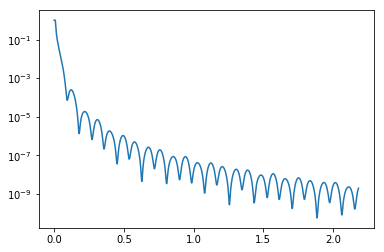

In [4]:
plt.semilogy(Q_VALUES,y)

In [5]:
kiesing_indices = []
crest_indices = []
for i in range(1,len(y)-1):
    y_1 = y[i-1]
    y0 = y[i]
    y1 = y[i+1]
    if( y_1 > y0 and y0 < y1 ):
        kiesing_indices.append(i)
    if( y_1 < y0 and y0 > y1 ):
        crest_indices.append(i)


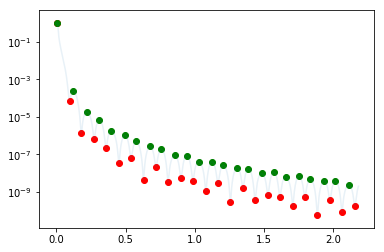

In [6]:
plt.semilogy(Q_VALUES,y,alpha=0.1)
plt.scatter(Q_VALUES[kiesing_indices],y[kiesing_indices],c='r')
plt.scatter(Q_VALUES[crest_indices],y[crest_indices],c='g')

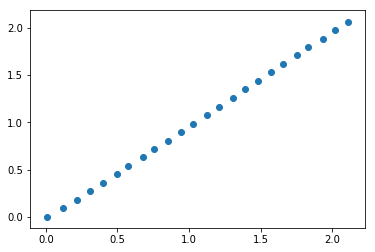

In [7]:
plt.scatter(Q_VALUES[crest_indices],Q_VALUES[kiesing_indices[:len(crest_indices)]])

highTiNi = Q_VALUES[crest_indices]
lowTiNi = Q_VALUES[kiesing_indices]

In [8]:
def run_two_slds(sld1,sld2):
    # set up the SLD objects for each layer
    sld_air = SLD(0.0 + 0.0j, name='air')
    sld_1 = SLD(sld1 + 0.0j, name='Ti')
    sld_2 = SLD(sld2 + 0.0j, name='Ni')
    sld_Si = SLD(2.0704 +  0.0j, name='Si')
    
    # set up the Slab objects for each layer
    slab_air = Slab(0.0, sld_air, 0.0, name='air_slab')
    slab_1 =  Slab(30.0, sld_1, 0.0, name ='Ti_slab')
    slab_2 =  Slab(70.0, sld_2, 0.0, name ='Ni_slab')
    slab_Si =  Slab(0.0, sld_Si, 0.0, name ='Si_slab')

    # set up the Structure object from the Slabs
    structure = Structure()
    
    structure.append(slab_air)
    for i in range(1):
        structure.append(slab_1)
        structure.append(slab_2)
    structure.append(slab_Si)
    
    reflectivity_values = refnx_reflectivity(structure,Q_VALUES)
    
    return reflectivity_values

In [9]:
s1 = -2.0
s2 =  9.0
r = run_two_slds(s1,s2)

In [10]:
def take_fingerprint(y):
    kiesing_indices = []
    crest_indices = []
    for i in range(1,len(y)-1):
        y_1 = y[i-1]
        y0 = y[i]
        y1 = y[i+1]
        if( y_1 > y0 and y0 < y1 ):
            kiesing_indices.append(i)
        if( y_1 < y0 and y0 > y1 ):
            crest_indices.append(i)
    return kiesing_indices, crest_indices

In [11]:
idx_low, idx_high = take_fingerprint(r)

In [12]:
low = Q_VALUES[idx_low]
high = Q_VALUES[idx_high]


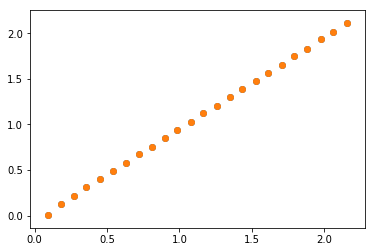

In [13]:
plt.scatter(low,high[1:])
plt.scatter(lowTiNi[1:],highTiNi)

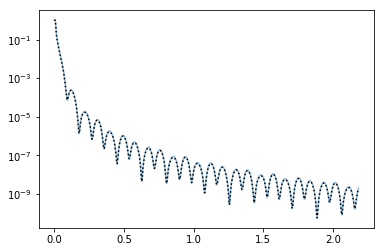

In [14]:
plt.semilogy(Q_VALUES,y, alpha=0.5)
plt.semilogy(Q_VALUES,r,'k:')

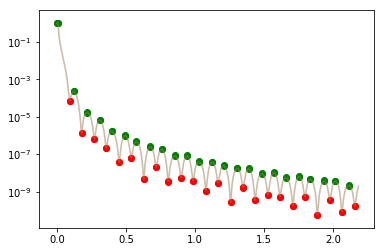

In [15]:
plt.semilogy(Q_VALUES,y,alpha=0.3)
plt.scatter(lowTiNi,y[kiesing_indices],c='r')
plt.scatter(highTiNi,y[crest_indices],c='g')

plt.semilogy(Q_VALUES,r,alpha=0.3)
plt.scatter(low,r[idx_low],c='r')
plt.scatter(high,r[idx_high],c='g')

In [16]:
print(low)
print(lowTiNi)

[0.09424013 0.17990852 0.27199259 0.35763919 0.45183109 0.53957805
 0.62943782 0.71926534 0.80691859 0.8988052  0.98637312 1.07816082
 1.16562547 1.25729545 1.34676841 1.43404453 1.52762869 1.61475488
 1.70816833 1.79512632 1.88411431 1.97512099 2.06179606 2.15681119]
[0.00428368 0.09424013 0.17990852 0.27199259 0.35763919 0.45183109
 0.53957805 0.62943782 0.71926534 0.80691859 0.8988052  0.98637312
 1.07816082 1.16562547 1.25729545 1.34676841 1.43404453 1.52762869
 1.61475488 1.70816833 1.79512632 1.88411431 1.97512099 2.06390885
 2.15681119]


In [17]:
def run_sld_thicknes_roughness(slds,thicknesses,roughnesses,qvals):
    assert len(slds) == len(thicknesses), "slds and thicknesses have different lengths"
    assert len(slds) == len(roughnesses), "slds and roughnesses have different lengths"
    
    structure = Structure()
    for i in range(len(slds)):
        m_sld = SLD(slds[i], name='sld'+str(i))
        slab = Slab(thicknesses[i], m_sld, roughnesses[i], name='slab'+str(i))
        structure.append(slab)
    
    reflectivity_values = refnx_reflectivity(structure,qvals)
    
    return reflectivity_values

# Single layer immersed in air:

In [18]:
def run_single_layer(s,th,q):
    slds = [0., s, 0]
    thicknesses = [0., th, 0.]
    roughnesses = [0.,  0., 0.]
    r = run_sld_thicknes_roughness(slds,thicknesses,roughnesses,q)
    return r

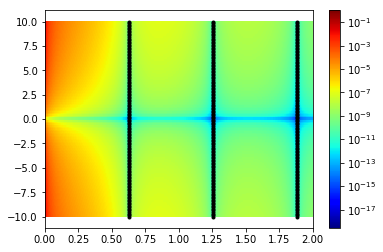

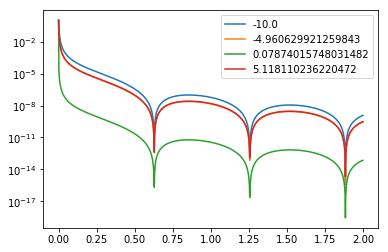

In [19]:
#Single Layer, varying SLD

qvals = np.linspace(0,2,1025)
refs = []
slds = []
fingerprints = {}
thickness = 10.
for sld in np.linspace(-10.,10.,128):
    slds.append(sld)
    ref = run_single_layer(sld,thickness,qvals)
    refs.append(ref)
    low, high = take_fingerprint(ref)
    fingerprints[sld] = qvals[low]
refs = np.asarray(refs)
slds = np.asarray(slds)
qvals = np.asarray(qvals)

import matplotlib.colors as colors
xx, yy = np.meshgrid(qvals, slds)
# Make the plot
plt.pcolormesh(xx, yy, refs, norm=colors.LogNorm(vmin=refs.min(), vmax=refs.max()), cmap='jet')
plt.colorbar()
for s in slds:
    plt.scatter(fingerprints[s],s*np.ones(len(fingerprints[s])),c='k',marker='.') 
plt.show()

for i in range(0,len(slds),len(slds)//4):
    plt.semilogy(qvals,refs[i], label = str(slds[i]))
plt.legend()
plt.show()


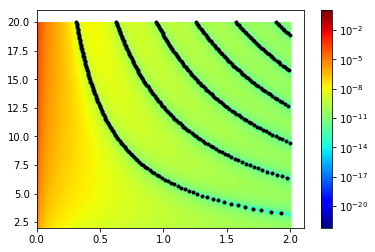

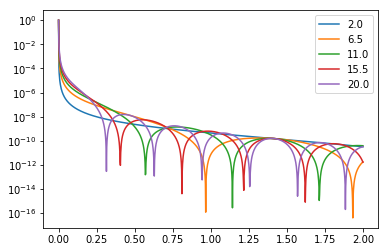

In [20]:
#Single Layer, varying thickness

qvals = np.linspace(0,2,1025)
refs = []
thicknesses = []
fingerprints = {}
sld = 1.
for thickness in np.linspace(2,20,129):
    thicknesses.append(thickness)
    ref = run_single_layer(sld,thickness,qvals)
    refs.append(ref)
    low, high = take_fingerprint(ref)
    fingerprints[thickness] = qvals[low]
refs = np.asarray(refs)
thicknesses = np.asarray(thicknesses)
qvals = np.asarray(qvals)

import matplotlib.colors as colors
xx, yy = np.meshgrid(qvals, thicknesses)
# Make the plot
plt.pcolormesh(xx, yy, refs, norm=colors.LogNorm(vmin=refs.min(), vmax=refs.max()), cmap='jet')
plt.colorbar()
for s in thicknesses:
    plt.scatter(fingerprints[s],s*np.ones(len(fingerprints[s])),c='k',marker='.') 
plt.show()

for i in range(0,len(thicknesses),len(thicknesses)//4):
    plt.semilogy(qvals,refs[i], label = str(thicknesses[i]))
plt.legend()
plt.show()

# Substrate only: semi-infinite slab

In [21]:
def run_substrate_only(s,th,q):
    slds = [0., s]
    thicknesses = [0., 0.]
    roughnesses = [0., 0.]
    r = run_sld_thicknes_roughness(slds,thicknesses,roughnesses,q)
    return r

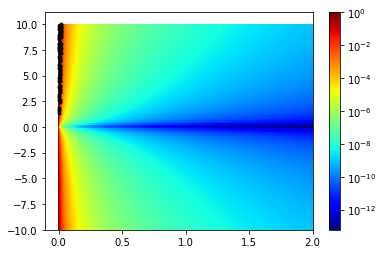

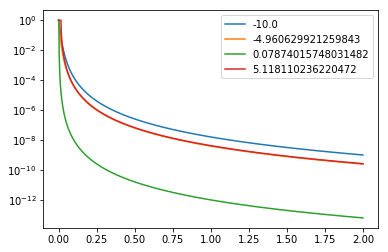

In [22]:
qvals = np.linspace(0,2,1025)
refs = []
slds = []
fingerprints = {}
thickness = 10.
for sld in np.linspace(-10.,10.,128):
    slds.append(sld)
    ref = run_substrate_only(sld,thickness,qvals)
    refs.append(ref)
    low, high = take_fingerprint(ref)
    fingerprints[sld] = qvals[low]
refs = np.asarray(refs)
slds = np.asarray(slds)
qvals = np.asarray(qvals)

import matplotlib.colors as colors
xx, yy = np.meshgrid(qvals, slds)
# Make the plot
plt.pcolormesh(xx, yy, refs, norm=colors.LogNorm(vmin=refs.min(), vmax=refs.max()), cmap='jet')
plt.colorbar()
for s in slds:
    plt.scatter(fingerprints[s],s*np.ones(len(fingerprints[s])),c='k',marker='.') 
plt.show()

for i in range(0,len(slds),len(slds)//4):
    plt.semilogy(qvals,refs[i], label = str(slds[i]))
plt.legend()
plt.show()

# Substrate + layer:

In [23]:
def run_layer_over_substrate(layer_sld, substrate_sld,layer_thickness,q):
    slds = [0., layer_sld, substrate_sld]
    thicknesses = [0., layer_thickness, 0.]
    roughnesses = [0.,  0., 0.]
    r = run_sld_thicknes_roughness(slds,thicknesses,roughnesses,q)
    return r

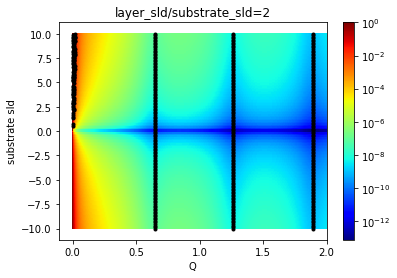

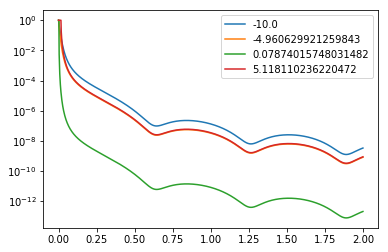

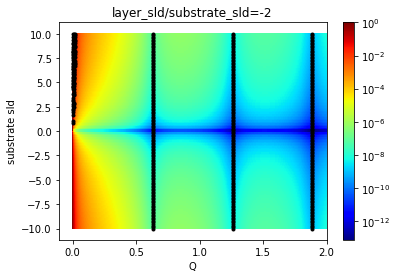

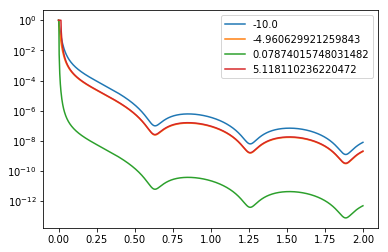

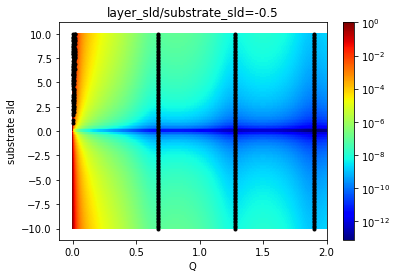

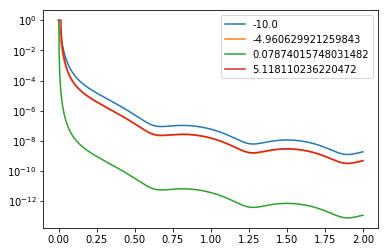

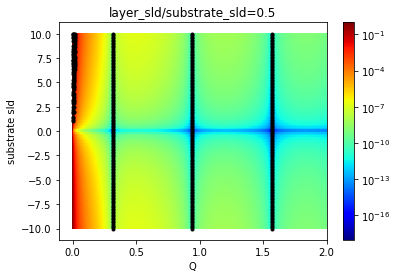

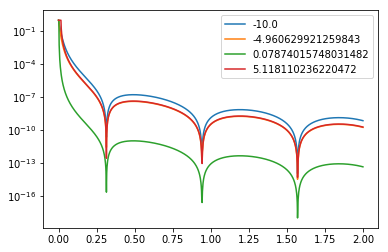

In [24]:
#Same thickness, varying sld:
def run_layer_over_substrate_with_sld_factor(factor):
    qvals = np.linspace(0,2,1025)
    refs = []
    slds = []
    fingerprints = {}
    thickness = 10.
    for sld in np.linspace(-10.,10.,128):
        slds.append(sld)
        ref = run_layer_over_substrate(factor*sld, sld,thickness,qvals)
        refs.append(ref)
        low, high = take_fingerprint(ref)
        fingerprints[sld] = qvals[low]
    refs = np.asarray(refs)
    slds = np.asarray(slds)
    qvals = np.asarray(qvals)
    
    import matplotlib.colors as colors
    xx, yy = np.meshgrid(qvals, slds)
    # Make the plot
    plt.pcolormesh(xx, yy, refs, norm=colors.LogNorm(vmin=refs.min(), vmax=refs.max()), cmap='jet')
    plt.colorbar()
    for s in slds:
        plt.scatter(fingerprints[s],s*np.ones(len(fingerprints[s])),c='k',marker='.') 
    plt.title("layer_sld/substrate_sld="+str(factor))
    plt.xlabel("Q")
    plt.ylabel("substrate sld")
    plt.show()
    
    for i in range(0,len(slds),len(slds)//4):
        plt.semilogy(qvals,refs[i], label = str(slds[i]))
    plt.legend()
    plt.show()
    
for f in [2,-2,-0.5,0.5]:
    run_layer_over_substrate_with_sld_factor(f)

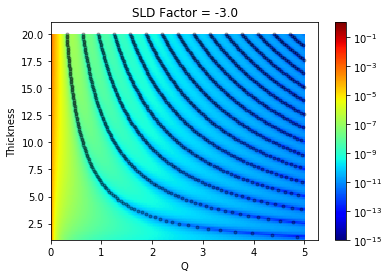

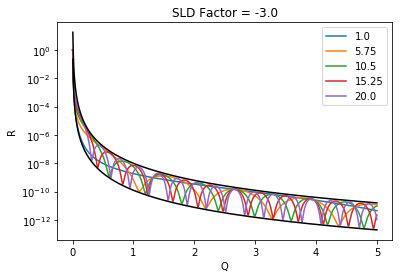

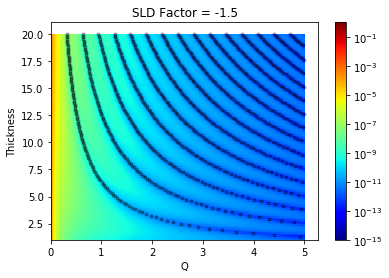

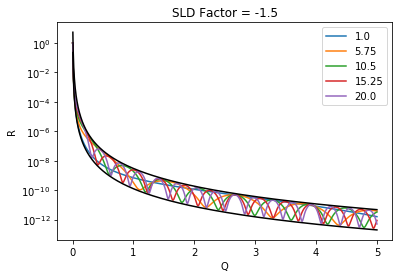

/home/juan/anaconda3/envs/refnx-paper/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


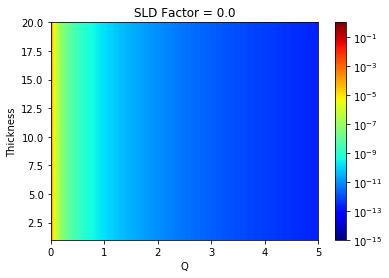

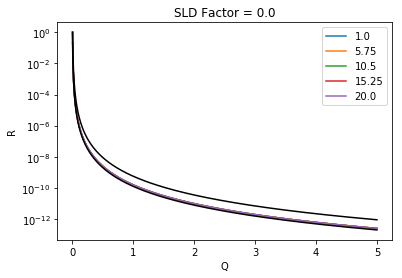

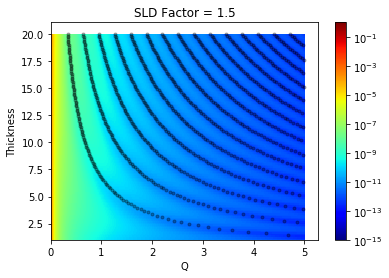

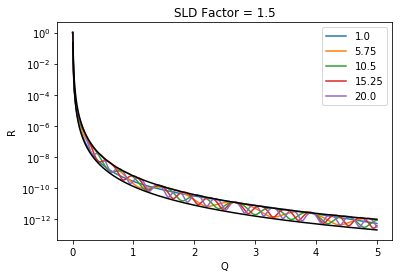

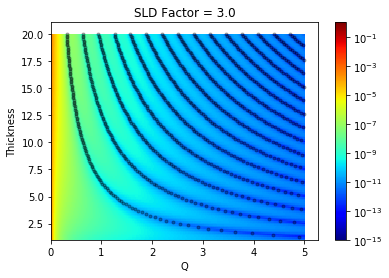

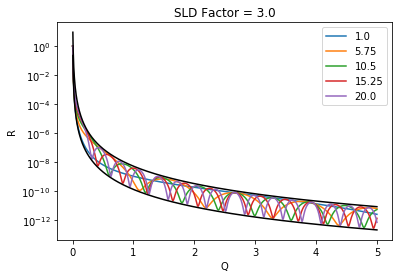

In [25]:
qvals = np.linspace(0,5,1025)
thicknesses = np.linspace(1,20,129)

sld = 1.
#for count, f in enumerate(np.linspace(-3.0,3.0,100)):
for count, f in enumerate(np.linspace(-3.0,3.0,5)):
    
    refs = []
    fingerprints = {}
    for thickness in thicknesses:
        ref = run_layer_over_substrate(f*sld,sld,thickness,qvals)
        refs.append(ref)
        low, high = take_fingerprint(ref)
        fingerprints[thickness] = qvals[low]
    refs = np.asarray(refs)
    qvals = np.asarray(qvals)
    
    import matplotlib.colors as colors
    xx, yy = np.meshgrid(qvals, thicknesses)
    # Make the plot
    plt.figure()
    plt.pcolormesh(xx, yy, refs, norm=colors.LogNorm(vmin=1e-15, vmax=1.1), cmap='jet')
    plt.colorbar()
    for s in thicknesses:
        plt.scatter(fingerprints[s],s*np.ones(len(fingerprints[s])),c='k',marker='.', alpha=0.3) 
    plt.xlabel("Q")
    plt.ylabel("Thickness")
    plt.title("SLD Factor = " + str(f))
    #plt.savefig("ConstantSLDfactorColormap_{:02}.png".format(count))
    #plt.close(fig='all')
    plt.show()
    
    
    plt.figure()
    for i in range(0,len(thicknesses),len(thicknesses)//4):
        plt.semilogy(qvals,refs[i], label = str(thicknesses[i]))
    
    multiplier = abs(1-f) * np.exp(abs(-f+f/2))
    plt.semilogy(qvals[1:],multiplier*(qvals[1:]/qvals[1])**-4,'k')
    plt.semilogy(qvals[1:],np.exp(-1.5)*(qvals[1:]/qvals[1])**-4,'k')
    plt.title("SLD Factor = " + str(f))
    plt.xlabel("Q")
    plt.ylabel("R")
    plt.legend()
    
    #plt.savefig("ConstantSLDfactorRefCurve_{:02}.png".format(count))
    #plt.close(fig='all')
    plt.show()

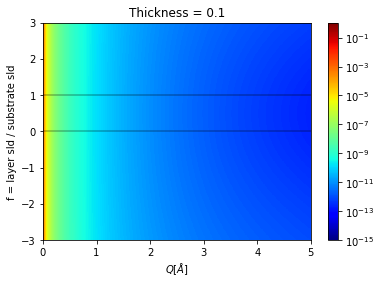

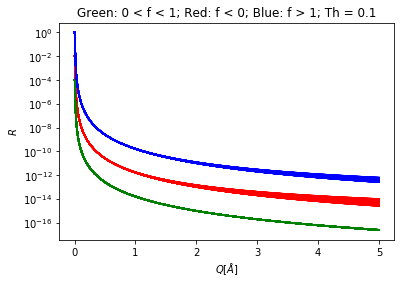

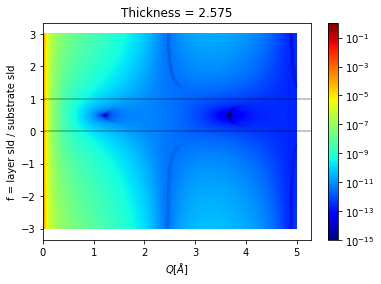

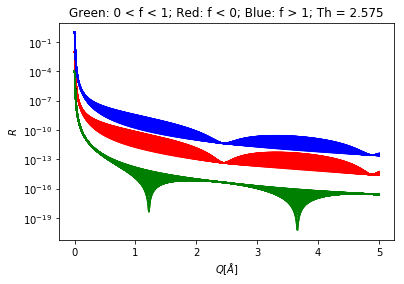

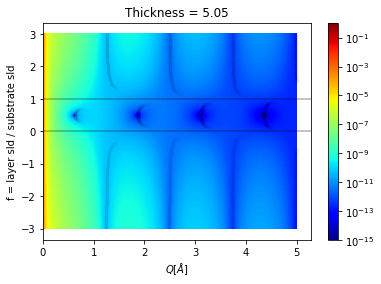

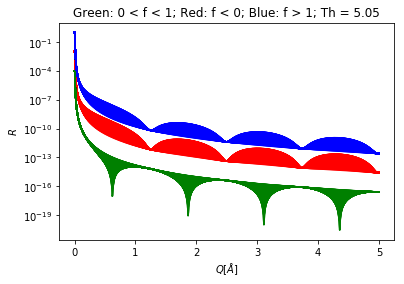

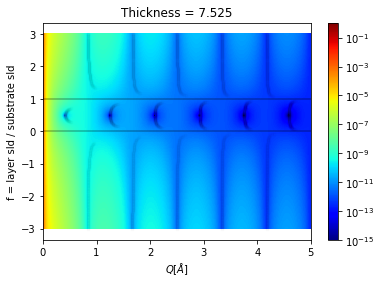

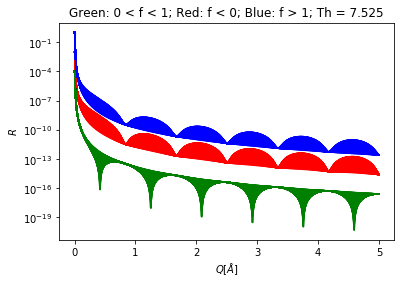

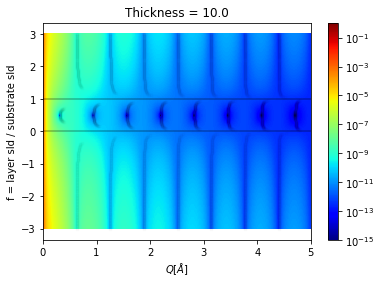

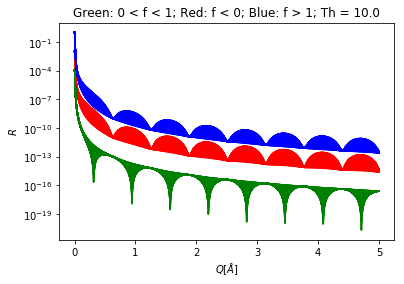

In [26]:
qvals = np.linspace(0,5,1025)
sld = 1.

factors = np.concatenate([
    np.linspace(-3.,0.,128, endpoint=False),
    np.linspace(1.0/128.,1.,128, endpoint=False),
    np.linspace(1.,3.,128)
]
)

#for count, thickness in enumerate(np.linspace(0.1,10,100)):
for count, thickness in enumerate(np.linspace(0.1,10,5)):

    refs = []
    fingerprints = {}
    for factor in factors:
        ref = run_layer_over_substrate(factor*sld,sld,thickness,qvals)
        refs.append(ref)
        low, high = take_fingerprint(ref)
        fingerprints[factor] = qvals[low]
    refs = np.asarray(refs)
    qvals = np.asarray(qvals)
    
    import matplotlib.colors as colors
    xx, yy = np.meshgrid(qvals, factors)
    # Make the plot
    
    plt.figure()
    plt.pcolormesh(xx, yy, refs, norm=colors.LogNorm(vmin=1e-15, vmax=1.1), cmap='jet')
    plt.colorbar()
    for s in factors:
        plt.scatter(fingerprints[s],s*np.ones(len(fingerprints[s])),c='k',marker='.', alpha=0.01) 
    plt.axhline(1.0, c='k', alpha=0.3)
    plt.axhline(0.0, c='k',alpha=0.3)
    plt.xlabel("$Q[\AA]$")
    plt.ylabel("f = layer sld / substrate sld")
    plt.title("Thickness = "+str(thickness))
    #plt.savefig("ThicknessColorMap_{:02}.png".format(count))
    #plt.close(fig='all')
    plt.show()
    
    
    plt.figure()
    for i in range(0,len(factors)):
        if factors[i] < 0:
            plt.semilogy(qvals,1e-2*refs[i], "r", label = str(factors[i]))
        elif factors[i] < 1:
            plt.semilogy(qvals,1e-4*refs[i], "g", label = str(factors[i]))
        else:
            plt.semilogy(qvals,refs[i], "b", label = str(factors[i]))
    
    plt.xlabel("$Q[\AA]$")
    plt.ylabel("$R$")
    plt.title("Green: 0 < f < 1; Red: f < 0; Blue: f > 1; Th = "+str(thickness))
    #plt.savefig("ThicknessRefCurve_{:02}.png".format(count))
    #plt.close(fig='all')
    plt.show()
    

In [27]:
def run_layers_over_substrate(substrate_sld, layers_slds,layers_thicknesses,q):
    slds = [0.] + layers_slds + [substrate_sld]
    thicknesses = [0.] + layers_thicknesses + [0.]
    roughnesses = [0. for _ in thicknesses]
    r = run_sld_thicknes_roughness(slds,thicknesses,roughnesses,q)
    return r

# Self-Similarity of the problem:

 - ### Rescaling to $Q$:

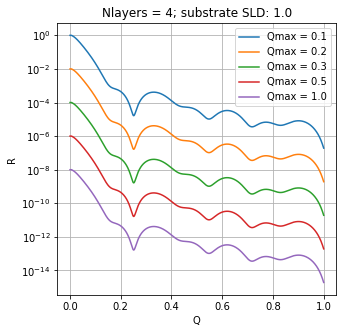

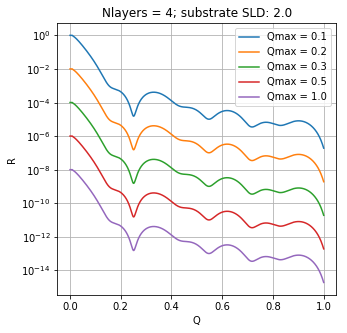

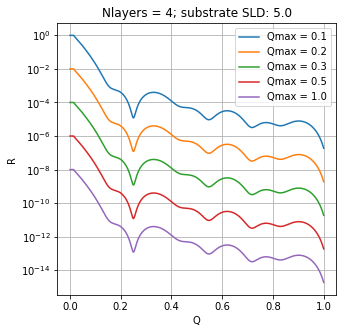

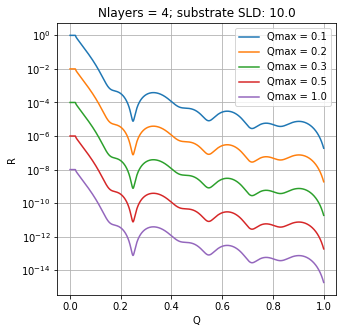

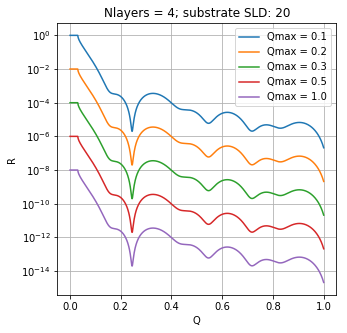

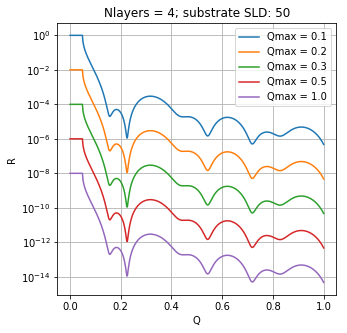

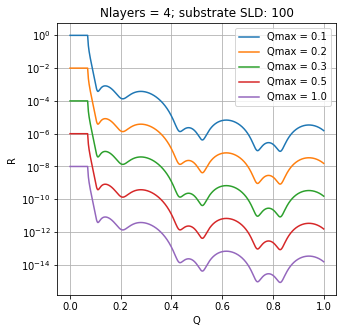

In [28]:
countfig = 0
power = 2.0
for substrate_sld in [1.0, 2.0, 5.0, 10.0, 20, 50, 100]:
    plt.figure(figsize=(5,5))
    plot_shift = 1.0
    for qmax in [ 0.10, 0.20, 0.30, 0.50, 1.00]:
        qvals = qmax * np.linspace(1e-3, 1.0, 1025)
        
        #rescale to qmax
        sub_sld = substrate_sld * qmax**2
        layers_slds = [qmax**2 * x for x in [30,70,50,90]]
        layers_thicknesses = [qmax**(-1) * x for x in [20,10,10, 5]]

        ref_signal = run_layers_over_substrate(sub_sld,layers_slds,layers_thicknesses,qvals)
    
        qvals /= qmax
        plt.semilogy(qvals,ref_signal*plot_shift, label = "Qmax = " + str(qmax))
        plot_shift *= 0.01
    
    
    plt.legend()
    plt.xlabel("Q")
    plt.ylabel("R")
    
    #plt.ylim([1e-7,1e-3])
    #plt.xlim([0.4,0.8])
    
    plt.title("Nlayers = " + str(len(layers_slds)) + "; substrate SLD: " + str(substrate_sld) )
    plt.grid()
    #plt.savefig("fig_{:02}.png".format(countfig))
    #plt.close(fig='all')
    plt.show()
    countfig+=1

 - ### Rescaling to $\rho_{\rm substrate}$:

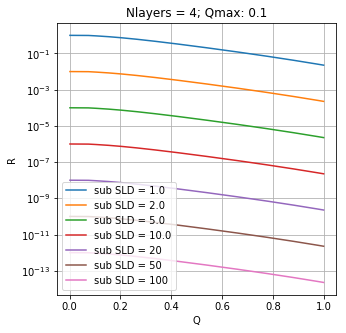

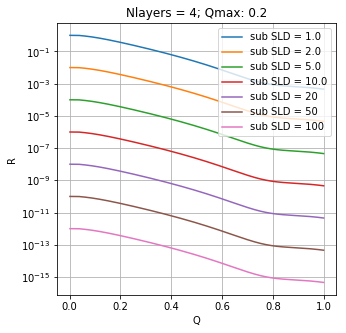

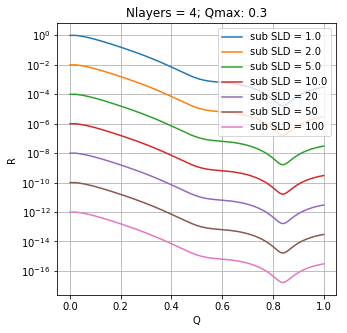

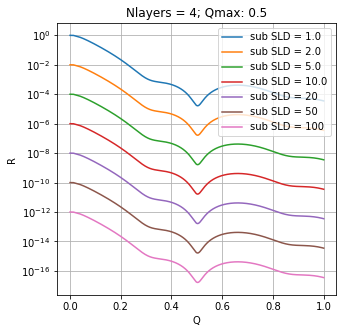

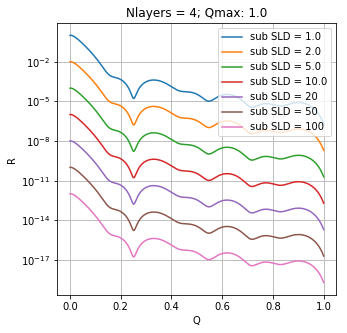

In [29]:
countfig = 0
power = 2.0
for qmax in [ 0.10, 0.20, 0.30, 0.50, 1.00]:
    plt.figure(figsize=(5,5))
    plot_shift = 1.0
    
    for substrate_sld in [1.0, 2.0, 5.0, 10.0, 20, 50, 100]:        
        
        #rescale to substrate_sld:
        scale_factor = np.sqrt(substrate_sld)
        qvals = scale_factor * qmax * np.linspace(1e-3, 1.0, 1025)
        layers_slds = [scale_factor**2 * x for x in [30,70,50,90]]
        layers_thicknesses = [scale_factor**(-1) * x for x in [20,10,10, 5]]

        ref_signal = run_layers_over_substrate(substrate_sld,layers_slds,layers_thicknesses,qvals)
    
        qvals /= (scale_factor*qmax)
        plt.semilogy(qvals,ref_signal*plot_shift, label = "sub SLD = " + str(substrate_sld))
        plot_shift *= 0.01
    
    
    plt.legend()
    plt.xlabel("Q")
    plt.ylabel("R")
    
    #plt.ylim([1e-7,1e-3])
    #plt.xlim([0.4,0.8])
    
    plt.title("Nlayers = " + str(len(layers_slds)) + "; Qmax: " + str(qmax) )
    plt.grid()
    #plt.savefig("fig_{:02}.png".format(countfig))
    #plt.close(fig='all')
    plt.show()
    countfig+=1

# Rescaling an experiment to fit the "unitless model":

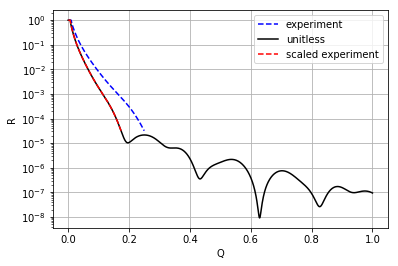

In [30]:
#### Experiment:

subs_from_experiment = 2.07
q_from_experiment = np.linspace(1e-3, 0.25, 1025)
slds_from_experiment = [x*subs_from_experiment for x in [20., 10, 4, 2]] #unknown
thicks_from_experiment = [x/np.sqrt(subs_from_experiment) for x in [30., 10, 20, 15]] #unknown
ref_from_experiment = run_layers_over_substrate(subs_from_experiment, 
                                                slds_from_experiment, 
                                                thicks_from_experiment,
                                                q_from_experiment)

### Experiment rescaled:

scaled_subs_sld = 1.0 # by definition is 1.0
scale_factor = np.sqrt(subs_from_experiment)
scaled_q = q_from_experiment / scale_factor
scaled_slds = [x / (scale_factor**2) for x in slds_from_experiment]
scaled_thicks = [x * scale_factor for x in thicks_from_experiment]
scaled_ref = run_layers_over_substrate(scaled_subs_sld, 
                                                scaled_slds, 
                                                scaled_thicks,
                                                scaled_q)

### Unitless model:

unit_sld_substrate = 1.0
unit_q = np.linspace(0.0, 1.0, 1025)
unitless_layer_slds = [x for x in [20., 10, 4, 2]] # We have to guess these numbers
unitless_layer_thicknesses = [x for x in [30., 10, 20, 15]] # We have to guess these numbers

unitless_reflectometry = run_layers_over_substrate(unit_sld_substrate, 
                                                unitless_layer_slds,
                                                unitless_layer_thicknesses,
                                                unit_q)


# compare experiment with unitless model

plt.semilogy(q_from_experiment, ref_from_experiment, 'b--' ,label = "experiment", alpha = 1.0)
plt.semilogy(unit_q, unitless_reflectometry, 'k-' ,label = "unitless")
plt.semilogy(scaled_q, scaled_ref, 'r--' ,label = "scaled experiment", alpha = 1.0)


plt.legend()
plt.xlabel("Q")
plt.ylabel("R")

plt.grid()
plt.show()

# The period depends on the thickness; the amplitude on the SLD:

 - In the natural units defined by the sld of the substrate, the kiessing finges appear with a period $\Delta Q = 2\pi / d$, where $d$ is the thickness of the layer; i.e. thicker layers produce more fringes for the same $Q$ range.
 - The amplitude of the $RQ^4$ signal evidently has a dependence on the sld of the layer on top of the substrate. In this simple example, we use two envelope functions for modelling the top and the bottom of the signal: a constant $1.5 \times 10^{-10}$ for the lower envelope and a function $ \sim \rho_{\rm layer}^2$ for the upper layer. 

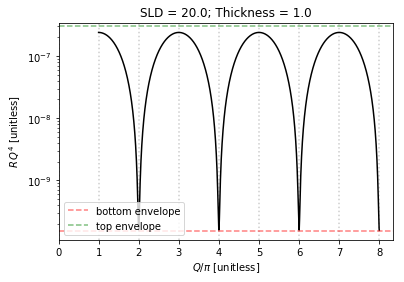

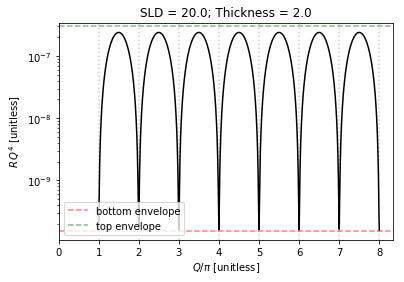

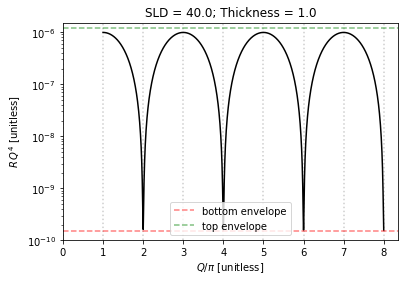

In [31]:
def plot_rq4(layer_sld, layer_thickness):

    unit_sld_substrate = 1.0
    unit_q = np.linspace(np.pi, 8.0*np.pi, 2049)
    unitless_layer_slds = [x for x in [layer_sld]] # We have to guess these numbers
    unitless_layer_thicknesses = [x for x in [layer_thickness]] # We have to guess these numbers
    
    unitless_reflectometry = run_layers_over_substrate(unit_sld_substrate, 
                                                    unitless_layer_slds,
                                                    unitless_layer_thicknesses,
                                                    unit_q)
    
    plt.semilogy(unit_q/np.pi, unit_q**4*unitless_reflectometry, 'k-')
    xmarks = [x for x in range(9)]
    plt.xticks(xmarks)
    for tick in xmarks:
        plt.axvline(tick, c='k', ls=':', alpha = 0.2)
        
    plt.axhline(1.5e-10, c='r', ls='--', alpha = 0.5, label = "bottom envelope")
    plt.axhline(7.5e-10*layer_sld**2, c='g', ls='--', alpha = 0.5, label = "top envelope")
    plt.xlabel("$Q / \pi \,\, [{\\rm unitless}]$")
    plt.ylabel("$R\,Q^4 \,\, [{\\rm unitless}]$")
    plt.legend()
    plt.title("SLD = {}; Thickness = {}".format(layer_sld, layer_thickness))
    plt.show()



#LAYER_SLD = 13.0
#LAYER_THICKNESS = 1.0

plot_rq4(20.0,1.0)
plot_rq4(20.0,2.0)
plot_rq4(40.0,1.0)





# The envelopes of the signal:

The top and the bottom envelopes of the $RQ^4$ signal vary as function of the layer SLD. The following cell shows this variation

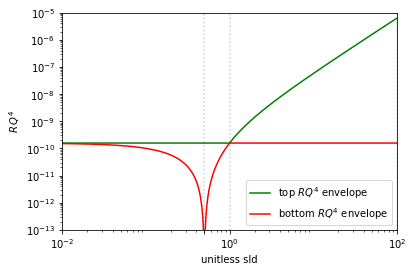

In [32]:
LAYER_THICKNESS = 1.0
peaks = []
valleys = []
layer_slds = []
for LAYER_SLD in np.logspace(-3,3,1025):
    unit_sld_substrate = 1.0
    unit_q = np.linspace(2.0*np.pi, 8.0*np.pi, 2049)
    unitless_layer_slds = [x for x in [LAYER_SLD]] # We have to guess these numbers
    unitless_layer_thicknesses = [x for x in [LAYER_THICKNESS]] # We have to guess these numbers
    
    unitless_reflectometry = run_layers_over_substrate(unit_sld_substrate, 
                                                unitless_layer_slds,
                                                unitless_layer_thicknesses,
                                                unit_q)

    peak = max(unit_q**4*unitless_reflectometry)
    valley = min(unit_q**4*unitless_reflectometry)
    peaks.append(peak)
    valleys.append(valley)
    layer_slds.append(LAYER_SLD)

peaks = np.asarray(peaks)
valleys = np.asarray(valleys)
layer_slds = np.asarray(layer_slds)

plt.loglog(layer_slds,peaks, 'g-', label = "top $RQ^4$ envelope")
plt.loglog(layer_slds,valleys, 'r-', label = "bottom $RQ^4$ envelope")

xmarks = [0.01,0.5,1,100]
plt.xticks(xmarks)
plt.xlim([xmarks[0],xmarks[-1]])
plt.ylim([1e-13,1e-5])
plt.xlabel("unitless sld")
plt.ylabel("$R\,Q^4$")
for tick in xmarks:
    plt.axvline(tick, c='k', ls=':', alpha = 0.2)
    
plt.legend()
plt.show()

## Try to model this variation with some simple functions:

 - top envelope = $\max(f,g)$,
 - bottom envelope = $\min(f,g)$,

where $f$ and $g$ are defined as follows:

$$f = 2\pi\,(\rho-1/2)^{2} \times 10^{-10},$$
$$g = {\rm const} = 2\pi\,(1/2)^{2} \times 10^{-10}$$

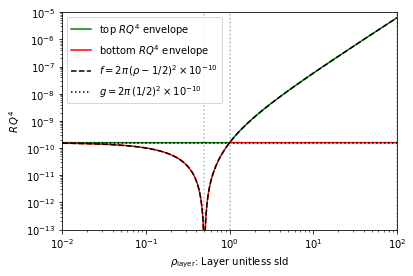

In [33]:
plt.loglog(layer_slds,peaks, 'g-', label = "top $RQ^4$ envelope")
plt.loglog(layer_slds,valleys, 'r-', label = "bottom $RQ^4$ envelope")
plt.loglog(layer_slds,2*np.pi*1e-10*(layer_slds-0.5)**(2),'k--', label = "$f = 2\pi\,(\\rho-1/2)^{2} \\times 10^{-10}$")
plt.axhline(2*np.pi*1e-10*(0.5)**2,c='k', ls=':', label = "$g = 2\pi\,(1/2)^{2} \\times 10^{-10}$")

xmarks = [0.01,0.5,1,100]
plt.xlim([1e-2,1e2])
plt.ylim([1e-13,1e-5])
plt.xlabel("$\\rho_{\\rm layer}$: Layer unitless sld")
plt.ylabel("$R\,Q^4$")
for tick in xmarks:
    plt.axvline(tick, c='k', ls=':', alpha = 0.3)
    
plt.legend()
plt.show()

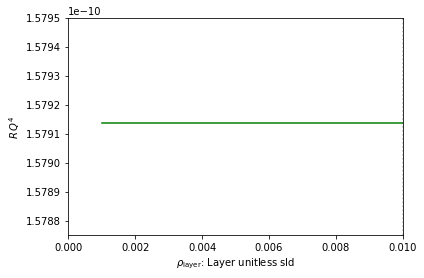

1.579125e-10


In [34]:
plt.plot(layer_slds,peaks, 'g-', label = "top $RQ^4$ envelope")
plt.plot(layer_slds,valleys, 'r-', label = "bottom $RQ^4$ envelope")
plt.plot(layer_slds,2*np.pi*1e-10*(layer_slds-0.5)**(2),'k--', label = "$f = 2\pi\,(\\rho-1/2)^{2} \\times 10^{-10}$")
plt.axhline(2*np.pi*1e-10*(0.5)**2,c='k', ls=':', label = "$g = 2\pi\,(1/2)^{2} \\times 10^{-10}$")

numerical_factor = 1e-09#(4*np.pi)**(-.5)


plt.axhline(numerical_factor*(0.5)**2,c='k', ls='-.', label = "$g = 2\pi\,(1/2)^{2} \\times 10^{-10}$")

#plt.plot(layer_slds,numerical_factor*(layer_slds-0.5)**(2),'k-.', label = "$f = 2\pi\,(\\rho-1/2)^{2} \\times 10^{-10}$")
ymin = 1.5787499999999998e-10
ymax = 1.5795e-10
xmarks = [0.01,0.5,1,100]
plt.xlim([0,1e-2])
plt.ylim([ymin,ymax])
plt.xlabel("$\\rho_{\\rm layer}$: Layer unitless sld")
plt.ylabel("$R\,Q^4$")
for tick in xmarks:
    plt.axvline(tick, c='k', ls=':', alpha = 0.3)
    
#plt.legend()
plt.show()
print(0.5*(ymax+ymin))

## Plot the $RQ^4$ profile of some multilayers

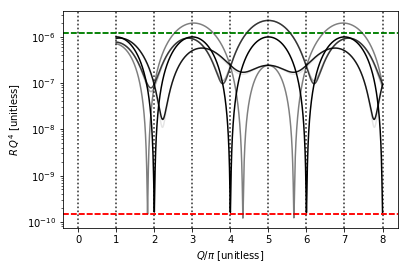

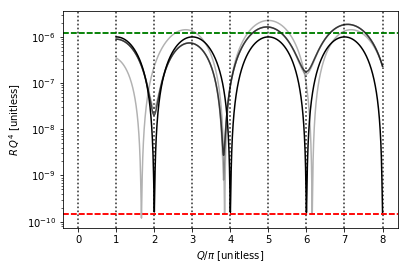

In [35]:
def plot_multilayer_rq4(layer_sld_list, layer_thickness_list, alpha=1.0, title=""):
    
    max_sld = max(layer_sld_list)
    max_thickness = max(layer_thickness_list)

    unit_sld_substrate = 1.0
    unit_q = np.linspace(np.pi, 8.0*np.pi, 2049)
    unitless_layer_slds = [x for x in layer_sld_list]
    unitless_layer_thicknesses = [x for x in layer_thickness_list]
    
    unitless_reflectometry = run_layers_over_substrate(unit_sld_substrate, 
                                                    unitless_layer_slds,
                                                    unitless_layer_thicknesses,
                                                    unit_q)
    
    plt.semilogy(unit_q/np.pi, unit_q**4*unitless_reflectometry, 'k-', alpha=alpha)
    xmarks = [x for x in range(9)]
    plt.xticks(xmarks)
    for tick in xmarks:
        plt.axvline(tick, c='k', ls=':', alpha = 0.2)
        
    plt.axhline(1.5e-10, c='r', ls='--', alpha = 0.5, label = "bottom envelope")
    plt.axhline(7.5e-10*max_sld**2, c='g', ls='--', alpha = 0.5, label = "top envelope")
    plt.xlabel("$Q / \pi \,\, [{\\rm unitless}]$")
    plt.ylabel("$R\,Q^4 \,\, [{\\rm unitless}]$")
    #plt.legend()
    #plt.title("maxSLD = {}; maxThickness = {}".format(max_sld, max_thickness))
    plt.title(title)

#LAYER_SLD = 13.0
#LAYER_THICKNESS = 1.0
plot_multilayer_rq4([40,40,40,40,40], [1/5,1/5,1/5,1/5,1/5], alpha=1.0)
plot_multilayer_rq4([20,40,40,40,40], [1/5,1/5,1/5,1/5,1/5], alpha=0.1)
plot_multilayer_rq4([40,20,40,40,40], [1/5,1/5,1/5,1/5,1/5], alpha=0.3)
plot_multilayer_rq4([40,40,20,40,40], [1/5,1/5,1/5,1/5,1/5], alpha=0.5)
plot_multilayer_rq4([40,40,40,20,40], [1/5,1/5,1/5,1/5,1/5], alpha=0.7)
plot_multilayer_rq4([40,40,40,40,20], [1/5,1/5,1/5,1/5,1/5], alpha=0.9)
plt.show()

plot_multilayer_rq4([40,40,40,40,40], [1/5, 1/5, 1/5, 1/5, 1/5], alpha=1.0)
plot_multilayer_rq4([40,40,20,40,40], [3./5, 0.5/5, 0.5/5, 0.5/5, 0.5/5], alpha=0.1)
plot_multilayer_rq4([40,40,20,40,40], [.5/5, 3./5, 0.5/5, 0.5/5, 0.5/5], alpha=0.2)
plot_multilayer_rq4([40,40,20,40,40], [.5/5, 0.5/5, 3./5, 0.5/5, 0.5/5], alpha=0.3)
plot_multilayer_rq4([40,40,20,40,40], [.5/5, 0.5/5, 0.5/5, 3./5, 0.5/5], alpha=0.4)
plot_multilayer_rq4([40,40,20,40,40], [.5/5, 0.5/5, 0.5/5, 0.5/5, 3./5], alpha=0.5)
plt.show()

In [36]:
def compute_q_vs_rq4(layer_sld_list, layer_thickness_list, qrange=[-16.0*np.pi, 16.0*np.pi], num_of_samples = 129):
    unit_sld_substrate = 1.0
    unit_q = np.linspace(qrange[0], qrange[1], num_of_samples)
    unitless_layer_slds = [x for x in layer_sld_list] # We have to guess these numbers
    unitless_layer_thicknesses = [x for x in layer_thickness_list] # We have to guess these numbers
    
    unitless_reflectometry = run_layers_over_substrate(unit_sld_substrate, 
                                                    unitless_layer_slds,
                                                    unitless_layer_thicknesses,
                                                    unit_q)
    return unit_q, unit_q**4*unitless_reflectometry

# A $\rho(z)$ step-up function produces a $\sin^2(q)$ signal in the $RQ^4$ space:


$RQ^4(q) = R_0 \, \sin^2\left(\frac{(1 - z_0)}{2}\,q\right)$,

where the amplitude, $R_0$ is given by (see some cells above in this notebook):

$R_0 = 2\pi \, (\rho_0- 1/2)^2 \, \times \,10^{-10}$

Te frequency is related to the position of the step and the amplitude to its height.

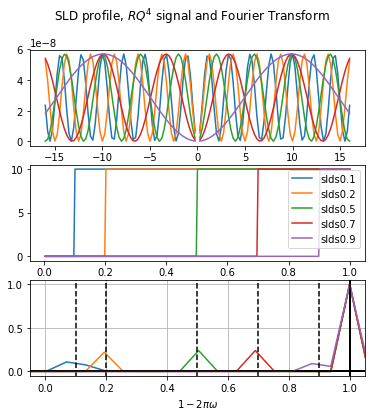

In [38]:
from tqdm import tqdm_notebook as tqdm
from scipy.special import sh_legendre
from scipy.fftpack import fft, ifft, idct, dct, rfft, fftshift, fftfreq

def step_up(xarr, x0, y0 = 0, y1 = 1):
    y = np.asarray([y0 if x < x0 else y1 for x in xarr])
    return y

number_of_layers = 257
thicknesses = np.ones(number_of_layers) / number_of_layers
depth = thicknesses.cumsum() 
 
slds = {}
refsignal = {}
for x0 in [0.1,0.2,0.5,0.7,0.9]:
    slds[x0] = step_up(depth, x0, y0 = 0, y1 = 10)#sh_legendre(i)(depth)
    q, refsignal[x0] = compute_q_vs_rq4(slds[x0], thicknesses)

R = {}
for x0 in refsignal.keys():
    R[x0] = (refsignal[x0])

fig, axs = plt.subplots(3, figsize=(6,6))
fig.suptitle('SLD profile, $RQ^4$ signal and Fourier Transform')
height = 2*np.pi*1e-10*(10-0.5)**(2)
for x0 in refsignal.keys():
    axs[0].plot(q/np.pi, R[x0], label = "r{}".format(x0))
    axs[1].plot(depth, slds[x0], label = "slds{}".format(x0))
    #axs[0].plot(q/np.pi, height*np.sin(0.5*q*(1 - x0))**2, 'k-', label = "sin(q)")
    #axs[0].plot(q/np.pi, height*0.5*(1 - np.cos(q*(1-x0))), 'k-', label = "sin(q)")
    
### Fourier:   
    r = np.nan_to_num(R[x0])
    stepsize= q[1]-q[0]
    fourier = (fft(r).real)
    freq = (fftfreq(q.size, d=stepsize))
    
    axs[2].plot(1-(fftshift(freq)*2*np.pi), fftshift(fourier**2/fourier[0]**2), '-')
    axs[2].grid()
    axs[2].axvline(1, c='k')
    axs[2].axhline(0, c='k')
    axs[2].axvline((x0), c='k', ls="--")
    axs[2].set_xlim(-0.05,1.05)
    axs[2].set_xlabel("$1-2\pi\omega$")


###
axs[1].legend()
plt.show()

In [ ]:
from tqdm import tqdm_notebook as tqdm

#step-up profile:
def step_up(xarr, x0, y0 = 0, y1 = 1):
    y = np.asarray([y0 if x < x0 else y1 for x in xarr])
    return y

number_of_layers = 201
thicknesses = np.ones(number_of_layers) / number_of_layers
depth = thicknesses.cumsum() 
count = 0
for x0 in depth:
    slds = step_up(depth, x0, y0 = 0, y1 = 10)#sh_legendre(i)(depth)
    q, r = compute_q_vs_rq4(slds, thicknesses)
    
    fig, axs = plt.subplots(3, figsize=(6,6))
    fig.suptitle(f'SLD profile, $RQ^4$ signal and Fourier Transform; $x_0 = {x0:.3f}$')
    
    axs[0].plot(q/np.pi, r)
    axs[1].plot(depth, slds, label = "x0 = {}".format(x0))
    
    ### Fourier:   
    r = np.nan_to_num(r)
    stepsize= q[1]-q[0]
    fourier = (fft(r).real)
    freq = (fftfreq(q.size, d=stepsize))
    
    axs[2].plot(1-(fftshift(freq)*2*np.pi), fftshift(fourier**2/fourier[0]**2), '-')
    axs[2].grid()
    axs[2].axvline(1, c='k')
    axs[2].axhline(0, c='k')
    axs[2].axvline((x0), c='k', ls="--")
    axs[2].set_xlim(-0.05,1.05)
    axs[2].set_xlabel("$1-2\pi\omega$")
    
    plt.savefig("fig_{:03}.png".format(count))
    plt.close("all")
    count += 1
    #break

# Two $\rho(z)$ up-steps produce a cosines linear combination signal in the $RQ^4$ space:

$RQ^4(q) = a_0 + \sum a_{i} \cos( \, (1-\delta_i z) \, q  )$

### Test: Fourier transform the signal to see which frequencies appear as spikes.

In [39]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def gaussian(xarr, mu=0, sig=1):
    return np.exp(-np.power(xarr - mu, 2.) / (2 * np.power(sig, 2.)))

def step_up(xarr, x0, y0 = 0, y1 = 1):
    y = np.asarray([y0 if x < x0 else y1 for x in xarr])
    return y

def step_down(xarr, x0, y0 = 0, y1 = 1):
    y = np.asarray([y1 if x < x0 else y0 for x in xarr])
    return y


number_of_layers = 257
thicknesses = np.ones(number_of_layers) / number_of_layers
depth = thicknesses.cumsum() 
 
slds = {}
refsignal = {}
x0, x1 = 0.3, 0.7
slds[(x0,x1)] = step_up(depth, x0, y0 = 0, y1 = 5) + \
                step_up(depth, x1, y0 = 0, y1 = 5)
q, refsignal[(x0,x1)] = compute_q_vs_rq4(slds[(x0,x1)], thicknesses)

R = {}
for x01 in refsignal.keys():
    R[x01] = (refsignal[x01])


def f(step0, step1, step2, step3, rescale):
    fig, axs = plt.subplots(3, figsize=(6,6))
    fig.suptitle('$RQ^4$ signal; SLD profile; $RQ^4$ Fourier Transform')
    for x01 in refsignal.keys():
        x0 = x01[0]
        x1 = x01[1]
        
        height0 = 2*np.pi*(step0-0.5)**(2)
        height1 = 2*np.pi*(step1-0.5)**(2)
        height2 = 2*np.pi*(step2-0.5)**(2)
        height3 = 2*np.pi*(step3-0.5)**(2)
        
        
        f0 = np.ones(q.shape)
        f1 = np.cos(q*(1-x1))
        f2 = np.cos(q*(1-x0))
        f3 = np.cos(q*(x1-x0))
        
        rescale = 1.0e-10 * rescale
        transform = rescale*(
            height0*f0 + 
            (-height1)*f1 + 
            (-height2)*f2 + 
            height3*f3
        )
        axs[0].plot(q/np.pi, R[x01], label = "r{}".format(x01))
        axs[1].plot(depth, slds[x01], label = "slds{}".format(x01))
        axs[0].plot(q/np.pi, transform, 'k-', label = "sin(q)")
        
    axs[1].axhline(0, c='k', ls='--', alpha = 0.5)
    axs[0].legend()
    axs[1].legend()
    
    
    ### Fourier:   
    r = np.nan_to_num(R[x01])
    stepsize= q[1]-q[0]
    fourier = (fft(r).real)
    freq = (fftfreq(q.size, d=stepsize))
    
    axs[2].plot(1-(fftshift(freq)*2*np.pi), fftshift(fourier**2/fourier[0]**2), '-')
    axs[2].grid()
    axs[2].axvline(1, c='k')
    axs[2].axhline(0, c='k')
    axs[2].axvline((x0), c='k', ls="--")
    axs[2].axvline((x1), c='k', ls="--")
    axs[2].set_xlim(-0.05,1.05)
    axs[2].set_xlabel("$1-2\pi\omega$")
    
    
    
    plt.show()

print("Set values to: 6, 5, 5, 4; scaling 1.1")
interactive_plot = interactive(f, 
                               step0=(0, 12,.5), 
                               step1=(0, 10,.5), 
                               step2=(0, 10,.5), 
                               step3=(0, 8,.5), 
                               rescale=(-18, 20,.1),
                              )
output = interactive_plot.children[-1]
output.layout.height = '400px'
interactive_plot

Set values to: 6, 5, 5, 4; scaling 1.1


interactive(children=(FloatSlider(value=6.0, description='step0', max=12.0, step=0.5), FloatSlider(value=5.0, …

# A $\rho(z)$ step-down function produces a $\sin^2(q)$ signal in the $RQ^4$ space:


$RQ^4(q) = R_0 \, \sin^2\left(\frac{(z_0)}{2}\,q\right)$,

where the amplitude, $R_0$ is given by (see some cells above in this notebook):

$R_0 = 2\pi \, (\rho_0- 1/2)^2 \, \times \,10^{-10}$

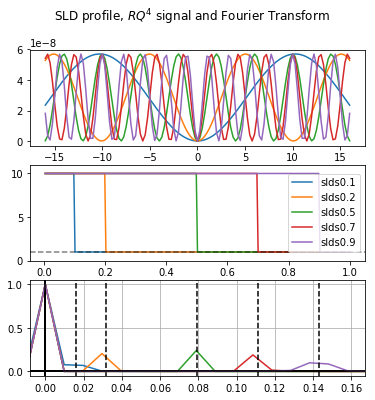

In [40]:
from tqdm import tqdm_notebook as tqdm
from scipy.special import sh_legendre

#gaussian profile:
def gaussian(xarr, mu=0, sig=1):
    return np.exp(-np.power(xarr - mu, 2.) / (2 * np.power(sig, 2.)))

def step_up(xarr, x0, y0 = 0, y1 = 1):
    y = np.asarray([y0 if x < x0 else y1 for x in xarr])
    return y

def step_down(xarr, x0, y0 = 0, y1 = 1):
    y = np.asarray([y1 if x <= x0 else y0 for x in xarr])
    return y


number_of_layers = 257
thicknesses = np.ones(number_of_layers) / number_of_layers
depth = thicknesses.cumsum() 
 
slds = {}
refsignal = {}
for x0 in [0.1,0.2,0.5,0.7,0.9]:
    slds[x0] = step_down(depth, x0, y0 = 1, y1 = 10)#sh_legendre(i)(depth)
    q, refsignal[x0] = compute_q_vs_rq4(slds[x0], thicknesses)

R = {}
for x0 in refsignal.keys():
    R[x0] = (refsignal[x0])

fig, axs = plt.subplots(3, figsize=(6,6))
fig.suptitle('SLD profile, $RQ^4$ signal and Fourier Transform')
height = 2*np.pi*1e-10*(10-0.5)**(2)
for x0 in refsignal.keys():
    axs[0].plot(q/np.pi, R[x0], label = "r{}".format(x0))
    axs[1].plot(depth, slds[x0], label = "slds{}".format(x0))
    #axs[0].plot(q/np.pi, height*np.sin(0.5*q*(x0))**2, 'k-', label = "sin(q)")
    #axs[0].plot(q/np.pi, height*0.5*(1 - np.cos(q*(x0))), 'k-', label = "sin(q)")
    
### Fourier:   
    r = np.nan_to_num(R[x0])
    stepsize= q[1]-q[0]
    fourier = (fft(r).real)
    freq = (fftfreq(q.size, d=stepsize))
    
    axs[2].plot(fftshift(freq), fftshift(fourier**2/fourier[0]**2), '-')
    axs[2].grid()
    axs[2].axvline(0, c='k')
    axs[2].axhline(0, c='k')
    axs[2].axvline((x0)/2/np.pi, c='k', ls="--")
    axs[2].set_xlim(-0.05/2/np.pi,1.05/2/np.pi)


###
axs[1].axhline(1, c='k', ls='--', alpha = 0.5)
axs[1].set_ylim(0,11)
axs[1].legend()
plt.show()

In [76]:
from tqdm import tqdm_notebook as tqdm

#step-down profile:
def step_down(xarr, x0, y0 = 0, y1 = 1):
    y = np.asarray([y1 if x <= x0 else y0 for x in xarr])
    return y

number_of_layers = 201
thicknesses = np.ones(number_of_layers) / number_of_layers
depth = thicknesses.cumsum() 
count = 0
for x0 in depth:
    slds = step_down(depth, x0, y0 = 1, y1 = 10)#sh_legendre(i)(depth)
    q, r = compute_q_vs_rq4(slds, thicknesses)
    
    
    fig, axs = plt.subplots(3, figsize=(6,6))
    fig.suptitle(f'SLD profile, $RQ^4$ signal and Fourier Transform; $x_0 = {x0:.3f}$')
    axs[0].set_ylim(-0.5e-8,6.5e-8)
    axs[0].plot(q/np.pi, r)
    axs[1].set_ylim(-2,12)
    axs[1].plot(depth, slds, label = f"$x_0 = {x0:.3f}$")
    axs[1].axhline(1, c='k', ls='--', alpha = 0.5, label = "$\\rho_{subs} := 1$")
    axs[1].legend()
    
    ### Fourier:   
    r = np.nan_to_num(r)
    stepsize= q[1]-q[0]
    fourier = (fft(r).real)
    freq = (fftfreq(q.size, d=stepsize))
    
    axs[2].plot((fftshift(freq)*2*np.pi), fftshift(fourier**2/fourier[0]**2), '-')
    axs[2].grid()
    axs[2].axvline(0, c='k')
    axs[2].axhline(0, c='k')
    axs[2].axvline((x0), c='k', ls="--")
    axs[2].set_xlim(-0.05,1.05)
    axs[2].set_xlabel("$2\pi\omega$")
    
    
    plt.savefig("fig_{:03}.png".format(count))
    plt.close("all")
    #plt.show()
    count += 1
    #break

# Two $\rho(z)$ down-steps produce a cosines linear combination signal in the $RQ^4$ space:

$RQ^4(q) = a_0 + \sum a_{i} \cos( \, (1-\delta_i z) \, q  )$

### Test: Fourier transform the signal to see which frequencies appear as spikes.

In [41]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def gaussian(xarr, mu=0, sig=1):
    return np.exp(-np.power(xarr - mu, 2.) / (2 * np.power(sig, 2.)))

def step_up(xarr, x0, y0 = 0, y1 = 1):
    y = np.asarray([y0 if x < x0 else y1 for x in xarr])
    return y

def step_down(xarr, x0, y0 = 0, y1 = 1):
    y = np.asarray([y1 if x <= x0 else y0 for x in xarr])
    return y


number_of_layers = 257
thicknesses = np.ones(number_of_layers) / number_of_layers
depth = thicknesses.cumsum() 
 
slds = {}
refsignal = {}
x0, x1 = 0.4, 0.5
slds[(x0,x1)] = step_down(depth, x0, y0 = 0, y1 = 5) + \
                step_down(depth, x1, y0 = 1, y1 = 5)
q, refsignal[(x0,x1)] = compute_q_vs_rq4(slds[(x0,x1)], thicknesses)

R = {}
for x01 in refsignal.keys():
    R[x01] = (refsignal[x01])


def f(step0, step1, step2, step3, rescale):
    fig, axs = plt.subplots(3, figsize=(6,6))
    fig.suptitle('SLD profile, $RQ^4$ signal and Fourier Transform')
    for x01 in refsignal.keys():
        x0 = x01[0]
        x1 = x01[1]
        
        height0 = 2*np.pi*(step0-0.5)**(2)
        height1 = 2*np.pi*(step1-0.5)**(2)
        height2 = 2*np.pi*(step2-0.5)**(2)
        height3 = 2*np.pi*(step3-0.5)**(2)
        
        
        f0 = np.ones(q.shape)
        f1 = np.cos(q*(x1))
        f2 = np.cos(q*(x0))
        f3 = np.cos(q*(x1-x0))
        
        rescale = 1.0e-10*rescale
        transform = rescale*(
            (height0)*f0 + 
            (-height1)*f1 + 
            (-height2)*f2 + 
            (height3)*f3
        )
        axs[0].plot(q/np.pi, R[x01], label = "r{}".format(x01))
        axs[1].plot(depth, slds[x01], label = "slds{}".format(x01))
        axs[0].plot(q/np.pi, transform, 'k-', label = "sin(q)")
        
    ### Fourier:   
    r = np.nan_to_num(R[x01])
    stepsize= q[1]-q[0]
    fourier = (fft(r).real)
    freq = (fftfreq(q.size, d=stepsize))
    
    axs[2].plot((fftshift(freq)*2*np.pi), fftshift(fourier**2/fourier[0]**2), '-')
    axs[2].grid()
    axs[2].axvline(0, c='k')
    axs[2].axhline(0, c='k')
    axs[2].axvline((x0), c='k', ls="--")
    axs[2].axvline((x1), c='k', ls="--")
    axs[2].set_xlim(-0.05,1.05)
    axs[2].set_xlabel("$2\pi\omega$")
        
    axs[1].axhline(0, c='k', ls='--', alpha = 0.5)
    axs[0].legend()
    axs[1].legend()
    plt.show()

print("Set values to: 6.5, 5, 5.5, 3.75 to have a good approx... but something is not ok")
interactive_plot = interactive(f, 
                               step0=(0, 13,0.25), 
                               step1=(0, 10,0.25), 
                               step2=(0, 11,0.25), 
                               step3=(0, 8,0.25), 
                               rescale=(0.1,2,0.1)
                              )
output = interactive_plot.children[-1]
output.layout.height = '420px'
interactive_plot

Set values to: 6.5, 5, 5.5, 3.75 to have a good approx... but something is not ok


interactive(children=(FloatSlider(value=6.0, description='step0', max=13.0, step=0.25), FloatSlider(value=5.0,…

# A $\rho(z)$ box function:

 - The position of the "box" does not change the $RQ^4$ profile.
 - Changing the width of the box is equivalent to changing the leftmost edge of a step-up function.


$$RQ^4(q) = R_0 \, \sin^2\left(\frac{(z1 - z_0)}{2}\,q\right),$$

where the amplitude, $R_0$ is given by (see some cells above in this notebook):

$$R_0 = 2\pi \, (\rho_0- 1/2)^2 \, \times \,10^{-10}$$

Te frequency is related to the position of the step and the amplitude to its height.

In [42]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

#box profile:
def box(xarr, x0, x1, height = 1):
    y = np.asarray([height if x < x1 and x >=x0 else 0 for x in xarr])
    return y

number_of_layers = 257
thicknesses = np.ones(number_of_layers) / number_of_layers
depth = thicknesses.cumsum() 
 

def f(position, width, height):
    x0 = position - 0.5*width
    x1 = position + 0.5*width
    slds = {}
    refsignal = {}
    slds[(x0,x1)] = box(depth, x0, x1, height) + box(depth,x1,1.0,1.0)
    q, refsignal[(x0,x1)] = compute_q_vs_rq4(slds[(x0,x1)], thicknesses)

    R = {}
    for x01 in refsignal.keys():
        R[x01] = (refsignal[x01])
    
    #Fourier:
    fourier = fft(np.nan_to_num(R[x01])).real
    stepsize = q[1] - q[0]
    freq = (fftfreq(q.size, d=stepsize))

    
    fig, axs = plt.subplots(3, figsize=(6,6))
    fig.suptitle(f'SLD profile, $RQ^4$ signal and Fourier Transform;')
    
    for x01 in refsignal.keys():
        axs[0].plot(q/np.pi, R[x01], label = "r{}".format(x01))
        axs[1].plot(depth, slds[x01], label = "$[x_0,x_1] = {}$".format(np.round(x01,3)))

        axs[2].plot((fftshift(freq)*2*np.pi), fftshift(fourier**2/fourier[0]**2), '-')
        axs[2].grid()
        axs[2].axvline(0, c='k')
        axs[2].axhline(0, c='k')
        axs[2].axvline((min(x1,1) - max(x0,0)), c='k', ls="--")
        axs[2].set_xlim(-0.05,1.05)
        axs[2].set_xlabel("$2\pi\omega$")
        
    axs[1].axhline(1, c='k', ls='--', alpha = 0.5, label="$\\rho_{\\rm subs}$")
    axs[1].legend()
    plt.show()
    
interactive_plot = interactive(f, 
                               position=(0.1, 0.9,.1),
                               width=(0.1, 0.9,.1),
                               height=(0, 10,.5),
                              )
output = interactive_plot.children[-1]
output.layout.height = '400px'
interactive_plot

interactive(children=(FloatSlider(value=0.5, description='position', max=0.9, min=0.1), FloatSlider(value=0.5,…

In [110]:
from tqdm import tqdm_notebook as tqdm
from scipy.special import sh_legendre

#box profile:
def box(xarr, x0, x1, height = 1):
    y = np.asarray([height if x < x1 and x >=x0 else 0 for x in xarr])
    return y


number_of_layers = 201
thicknesses = np.ones(number_of_layers) / number_of_layers
depth = thicknesses.cumsum() 
 
slds = {}
refsignal = {}
width = 0.1
count = 0
for position in np.linspace(width,1-width,100):
    #for width in [0.2, 0.3, 0.5]:
    x0 = position - 0.5*width
    x1 = position + 0.5*width
    slds = box(depth, x0, x1, 10) + box(depth,x1,1.0,1.0)
    q, r = compute_q_vs_rq4(slds, thicknesses)
    
    
    fig, axs = plt.subplots(3, figsize=(6,6))
    fig.suptitle(f'SLD profile, $RQ^4$ signal and Fourier Transform;')
    axs[0].set_ylim(-0.5e-8,6.5e-8)
    axs[0].plot(q/np.pi, r)
    axs[1].set_ylim(-2,12)
    axs[1].plot(depth, slds, label = "$x_1 - x_0 = {:.3f}$".format(min(x1,1) - max(x0,0)))
    axs[1].axhline(1, c='k', ls='--', alpha = 0.5, label = "$\\rho_{subs} := 1$")
    axs[1].legend()
    
    ### Fourier:   
    r = np.nan_to_num(r)
    stepsize= q[1]-q[0]
    fourier = (fft(r).real)
    freq = (fftfreq(q.size, d=stepsize))
    
    axs[2].plot((fftshift(freq)*2*np.pi), fftshift(fourier**2/fourier[0]**2), '-')
    axs[2].grid()
    axs[2].axvline(0, c='k')
    axs[2].axhline(0, c='k')
    axs[2].axvline((min(x1,1) - max(x0,0)), c='k', ls="--")
    axs[2].set_xlim(-0.05,1.05)
    axs[2].set_xlabel("$2\pi\omega$")
    
    plt.savefig("fig_{:03}.png".format(count))
    plt.close("all")
    plt.show()
    count += 1
    #break

position = 0.5
for width in np.linspace(0.1,0.9,100):
    #for width in [0.2, 0.3, 0.5]:
    x0 = position - 0.5*width
    x1 = position + 0.5*width
    slds = box(depth, x0, x1, 10) + box(depth,x1,1.0,1.0)
    q, r = compute_q_vs_rq4(slds, thicknesses)
    
    
    fig, axs = plt.subplots(3, figsize=(6,6))
    fig.suptitle(f'SLD profile, $RQ^4$ signal and Fourier Transform;')
    axs[0].set_ylim(-0.5e-8,6.5e-8)
    axs[0].plot(q/np.pi, r)
    axs[1].set_ylim(-2,12)
    axs[1].plot(depth, slds, label = "$x_1 - x_0 = {:.3f}$".format(min(x1,1) - max(x0,0)))
    axs[1].axhline(1, c='k', ls='--', alpha = 0.5, label = "$\\rho_{subs} := 1$")
    axs[1].legend()
    
    ### Fourier:   
    r = np.nan_to_num(r)
    stepsize= q[1]-q[0]
    fourier = (fft(r).real)
    freq = (fftfreq(q.size, d=stepsize))
    
    axs[2].plot((fftshift(freq)*2*np.pi), fftshift(fourier**2/fourier[0]**2), '-')
    axs[2].grid()
    axs[2].axvline(0, c='k')
    axs[2].axhline(0, c='k')
    axs[2].axvline((min(x1,1) - max(x0,0)), c='k', ls="--")
    axs[2].set_xlim(-0.05,1.05)
    axs[2].set_xlabel("$2\pi\omega$")
    
    plt.savefig("fig_{:03}.png".format(count))
    plt.close("all")
    plt.show()
    count += 1
    #break

## SLD gradient: --crazyness!

In [43]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def gaussian(xarr, mu=0, sig=1):
    return np.exp(-np.power(xarr - mu, 2.) / (2 * np.power(sig, 2.)))

def step_up(xarr, x0, y0 = 0, y1 = 1):
    y = np.asarray([y0 if x < x0 else y1 for x in xarr])
    return y

def step_down(xarr, x0, y0 = 0, y1 = 1):
    y = np.asarray([y1 if x <= x0 else y0 for x in xarr])
    return y

def box(xarr, x0, x1, height = 1):
    y = np.asarray([height if x < x1 and x >=x0 else 0 for x in xarr])
    return y


number_of_layers = 257
thicknesses = np.ones(number_of_layers) / number_of_layers
depth = thicknesses.cumsum() 
 
slds = {}
refsignal = {}
x0, x1 = 0.3, 0.6
slds[(x0,x1)] = 11 - 10*depth#box(depth, x1-0.2, x1+0.2, height=5) + \
                #step_up(depth, x0,0,1)
q, refsignal[(x0,x1)] = compute_q_vs_rq4(slds[(x0,x1)], thicknesses)

R = {}
for x01 in refsignal.keys():
    R[x01] = (refsignal[x01])


#def f(step0, step1, step2, step3, rescale):
def f(h0, h1, h2, h3, h4, rescale):
    fig, axs = plt.subplots(3, figsize=(6,6))
    fig.suptitle(f'SLD profile, $RQ^4$ signal and Fourier Transform;')
    for x01 in refsignal.keys():
        x0 = x01[0]
        x1 = x01[1]
        
        #height0 = 2*np.pi*(step0-0.5)**(2)
        #height1 = 2*np.pi*(step1-0.5)**(2)
        #height2 = 2*np.pi*(step2-0.5)**(2)
        #height3 = 2*np.pi*(step3-0.5)**(2)
        
        height0 = h0
        height1 = h1
        height2 = h2
        height3 = h3
        height4 = h4
        
        f0 = np.ones(q.shape)
        f1 = np.cos(q*(0.4))
        f2 = np.cos(q*(0.6))
        #f3 = np.cos(q*(0.25))
        #f4 = np.cos(q*(0.30))
        
        rescale = 1.0e-10*rescale
        transform = -rescale*(
            (height0)*f0 + 
            (height1)*f1 + 
            (height2)*f2  
        #    (height3)*f3 + 
        #    (height4)*f4 
        )
        axs[0].plot(q/np.pi, R[x01], label = "r{}".format(x01))
        axs[1].plot(depth, slds[x01], label = "slds{}".format(x01))
        axs[0].plot(q/np.pi, transform, 'k-', label = "sin(q)")
        
    axs[1].axhline(1, c='k', ls='--', alpha = 0.5, label = "$\\rho_{\\rm subs}$")
    axs[0].legend()
    axs[1].legend()
    
    
    ### Fourier:   
    r = np.nan_to_num(R[x01])
    stepsize= q[1]-q[0]
    fourier = (fft(r).real)
    freq = (fftfreq(q.size, d=stepsize))
    
    axs[2].semilogy((fftshift(freq)*2*np.pi), fftshift(fourier**2/fourier[0]**2), '-')
    axs[2].grid()
    axs[2].axvline(0, c='k')
    axs[2].axhline(0, c='k')
    axs[2].axvline((min(x1,1) - max(x0,0)), c='k', ls="--")
    axs[2].set_xlim(-0.05,1.2)
    axs[2].set_xlabel("$2\pi\omega$")
    
    
    
    plt.show()

#print("Set values to: 6.5, 5, 5.5, 3.75 to have a good approx... but something is not ok")
#interactive_plot = interactive(f, 
#                               step0=(0, 10,0.25), 
#                               step1=(0, 10,0.25), 
#                               step2=(0, 10,0.25), 
#                               step3=(0, 10,0.25),
#                               rescale=(0.1,2,0.1)
#                              )
interactive_plot = interactive(f, 
                               h0=(-100, 100,1.0),
                               h1=(-100, 100,1.0),
                               h2=(-100, 100,1.0),
                               h3=(-100, 100,1.0),
                               h4=(-100, 100,1.0),
                               rescale=(0.1,10,0.1)
                              )
output = interactive_plot.children[-1]
output.layout.height = '420px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='h0', min=-100.0, step=1.0), FloatSlider(value=0.0, d…

# FFT crash howt to: 

1. Do the inverse fourier transorm to see wether the original signal is recovered:
2. The spectrum of a noisy signal

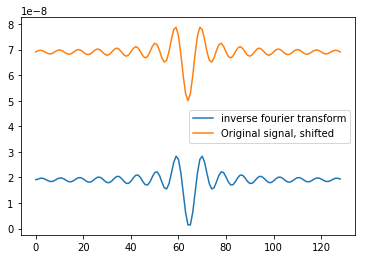

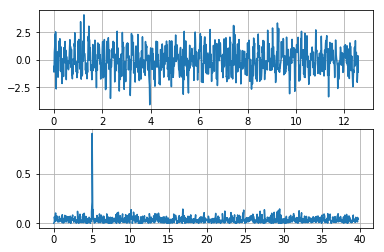

In [155]:
#1. Fourier-transform the rq4 signal
r = np.nan_to_num(R[x01])
stepsize= q[1]-q[0]
fourier = (fft(r).real)
freq = (fftfreq(q.size, d=stepsize))
#2. build cosines functions corresponding to each of the 
# frequencies of the fourier transform multiplying by the amplitude

#3 sum them up
inv_fourier = ifft((fourier))
plt.plot(inv_fourier, label = "inverse fourier transform")
plt.plot(r + 5e-8, label = "Original signal, shifted")
plt.legend()
plt.show()

def spectrum(sig, t):
    f = rfftfreq(sig.size, d=t[1]-t[0])
    y = rfft(sig)

    return f, y


if __name__ == "__main__":
    N = 1000
    t = np.linspace(0, 4*np.pi, N)
    x = np.sin(5*(2*np.pi*t))+np.random.randn(N)


    f, y = spectrum(x, t)

    plt.subplot(211)
    plt.plot(t,x)
    plt.grid(True)
    plt.subplot(212)
    y_a = np.abs(y)/N*2 # Scale accordingly
    plt.plot(f, y_a)
    plt.grid(True)
    plt.show()

    

# Prove that $R(\rho_a) + R(\rho_b) \neq R(\rho_a + \rho_b)$

In [44]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def gaussian(xarr, mu=0, sig=1):
    return np.exp(-np.power(xarr - mu, 2.) / (2 * np.power(sig, 2.)))

def step_up(xarr, x0, y0 = 0, y1 = 1):
    y = np.asarray([y0 if x < x0 else y1 for x in xarr])
    return y

def step_down(xarr, x0, y0 = 0, y1 = 1):
    y = np.asarray([y1 if x < x0 else y0 for x in xarr])
    return y

def box(xarr, x0, x1, height = 1):
    y = np.asarray([height if x < x1 and x >=x0 else 0 for x in xarr])
    return y


number_of_layers = 257
thicknesses = np.ones(number_of_layers) / number_of_layers
depth = thicknesses.cumsum() 
 

def f(position_a, width_a, position_b,width_b, height, rescale):
    x0a = position_a - 0.5*width_a
    x1a = position_a + 0.5*width_a
    
    x0b = position_b - 0.5*width_b
    x1b = position_b + 0.5*width_b
    
    slds = {}
    refsignal = {}
    SLDtotal = np.zeros(depth.size)
    for (x0,x1) in [(x0a,x1a),(x0b,x1b)]:
        slds[(x0,x1)] = box(depth, x0, x1, height)
        q, refsignal[(x0,x1)] = compute_q_vs_rq4(slds[(x0,x1)], thicknesses)
        SLDtotal += slds[(x0,x1)]

    R = {}
    Rsum = np.zeros(q.size)
    for x01 in refsignal.keys():
        R[x01] = (refsignal[x01])
        Rsum += R[x01]
    q, Rtotal = compute_q_vs_rq4(SLDtotal, thicknesses)
    
    
    fig, axs = plt.subplots(3,figsize=(7,7))
    fig.suptitle('SLD profile and $RQ^4$ signal')
    
    
    for x01 in refsignal.keys():
        axs[0].plot(q/np.pi, R[x01], label = "r({:.2f},{:.2f})".format(x01[0],x01[1]))
        axs[1].plot(depth, slds[x01], label = "slds = ({:.2f},{:.2f})".format(x01[0],x01[1]))
    
    axs[0].plot(q/np.pi, Rsum, 'k:')
    axs[1].plot(depth, SLDtotal, 'k:')
    axs[2].plot(q/np.pi, rescale*Rsum, label = "R(a)+R(b)")
    axs[2].plot(q/np.pi, Rtotal, label = "R(a+b)")
        
    axs[1].axhline(0, c='k', ls='--', alpha = 0.5)
    axs[0].legend()
    axs[1].legend()
    axs[2].legend()
    plt.show()

interactive_plot = interactive(f, 
                               position_a=(0, .5,.1),
                               width_a=(0, .2,.1),
                               position_b=(.5, 1,.1),
                               width_b=(0, .5,.1),
                               height=(0, 10,.5),
                               rescale=(-8, 10,.5),
                              )
output = interactive_plot.children[-1]
output.layout.height = '520px'
interactive_plot

interactive(children=(FloatSlider(value=0.2, description='position_a', max=0.5), FloatSlider(value=0.1, descri…

### Tried something with special functions:

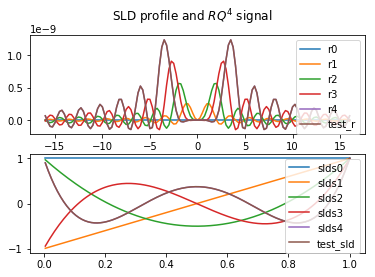

In [45]:
from scipy.special import chebyt
from scipy.special import chebyu
from scipy.special import chebys
from scipy.special import chebyc
from scipy.special import legendre

number_of_layers = 200
thicknesses = np.ones(number_of_layers) / number_of_layers
depth = thicknesses.cumsum() 
 

slds0 = legendre(0)(2*depth-1)
slds1 = legendre(1)(2*depth-1)# / (2+1)
slds2 = legendre(2)(2*depth-1)# / (2*2+1)
slds3 = legendre(3)(2*depth-1)# / (2*3+1)
slds4 = legendre(4)(2*depth-1)# / (2*4+1)

test_sld = slds4
q, test_r = compute_q_vs_rq4(test_sld, thicknesses)

q, r0 = compute_q_vs_rq4(slds0, thicknesses)
q, r1 = compute_q_vs_rq4(slds1, thicknesses)
q, r2 = compute_q_vs_rq4(slds2, thicknesses)
q, r3 = compute_q_vs_rq4(slds3, thicknesses)
q, r4 = compute_q_vs_rq4(slds4, thicknesses)



fig, axs = plt.subplots(2)
fig.suptitle('SLD profile and $RQ^4$ signal')

axs[0].plot(q/np.pi, r0-r0, label = "r0")
axs[0].plot(q/np.pi, r1-r0, label = "r1")
axs[0].plot(q/np.pi, r2-r0, label = "r2")
axs[0].plot(q/np.pi, r3-r0, label = "r3")
axs[0].plot(q/np.pi, (r4-r0), label = "r4")
axs[0].plot(q/np.pi, (test_r-r0), label = "test_r")
axs[0].legend()

axs[1].plot(depth, slds0, label = "slds0")
axs[1].plot(depth, slds1, label = "slds1")
axs[1].plot(depth, slds2, label = "slds2")
axs[1].plot(depth, slds3, label = "slds3")
axs[1].plot(depth, slds4, label = "slds4")
axs[1].plot(depth, test_sld, label = "test_sld")
axs[1].legend()

plt.show()

In [46]:
print(np.sum((slds1)*(slds1)))
print(np.sum((slds2)*(slds2)))
print(np.sum((slds3)*(slds3)))
print(np.sum((slds4)*(slds4)))
print("--")

print(np.sum((slds1)*(slds2)))
print(np.sum((slds1)*(slds3)))
print(np.sum((slds1)*(slds4)))
print("--")

print(np.sum((slds2)*(slds3)))
print(np.sum((slds2)*(slds4)))
print("--")

print(np.sum((slds3)*(slds4)))


66.67000000000012
40.00999985000013
28.591426988125143
22.255547472916803
--
1.0000000000001457
0.011666500000168778
1.000000000000158
--
1.0000000000001528
0.021665000031418025
--
1.0000000000001616


## Critical angle... how to get it? Yet unsolved...

0.002256758336839136


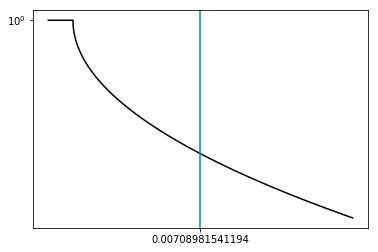

In [47]:
LAYER_SLD = 20
LAYER_THICKNESS = 1.0

### Unitless model:

unit_sld_substrate = 1.0
#unit_q = np.linspace(0.007089815402270508, 0.00708981540413086)#4.0*np.pi, 2049)
unit_q = np.linspace(0.0022567583336782723 * np.pi, 0.00225675834 * np.pi, 2049)
unitless_layer_slds = [x for x in [LAYER_SLD]] # We have to guess these numbers
unitless_layer_thicknesses = [x for x in [LAYER_THICKNESS]] # We have to guess these numbers

unitless_reflectometry = run_layers_over_substrate(unit_sld_substrate, 
                                                unitless_layer_slds,
                                                unitless_layer_thicknesses,
                                                unit_q)


critical_angle_approx = 0.5*(unit_q[-1]+unit_q[0])
plt.semilogy(unit_q, unitless_reflectometry, 'k-' ,label = "unitless model")
plt.xticks([critical_angle_approx])
plt.axvline(critical_angle_approx)
print(critical_angle_approx/np.pi)

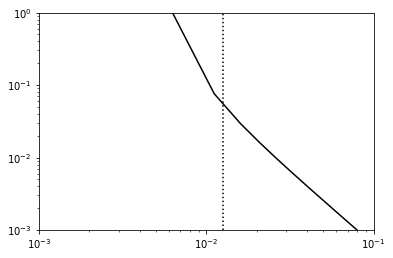

In [48]:
LAYER_SLD = 200
LAYER_THICKNESS = 1.0

### Unitless model:

unit_sld_substrate = 1.0
unit_q = np.linspace(0.002 * np.pi, 10, 2049)
unitless_layer_slds = [x for x in [LAYER_SLD]]
unitless_layer_thicknesses = [x for x in [LAYER_THICKNESS]]

unitless_reflectometry = run_layers_over_substrate(unit_sld_substrate, 
                                                unitless_layer_slds,
                                                unitless_layer_thicknesses,
                                                unit_q)

plt.loglog(unit_q, unitless_reflectometry, 'k-' ,label = "unitless model")
#plt.xticks([2*np.pi, 4*np.pi])
#plt.axvline(4*np.pi, c='k', ls=':')
#plt.axvline(2*np.pi, c='k', ls=':')
plt.axvline(0.004*np.pi, c='k', ls=':')
plt.ylim([1e-3,1.0])
plt.xlim([1e-3,1e-1])
plt.show()

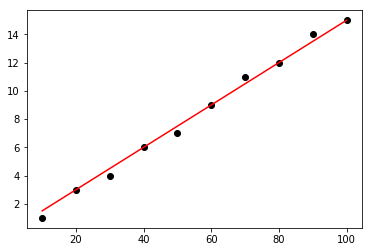

In [49]:
# 1 layer:
x = np.linspace(10,100,10)
n = .15*x
NpeaksVsLayerThickness = np.asarray([[10,1], [20,3], [30,4], [40,6], [50,7], [60,9], [70,11], [80,12], [90,14], [100,15] ]).T

plt.plot(NpeaksVsLayerThickness[0,:],NpeaksVsLayerThickness[1,:],'ko')
plt.plot(x,n,'r-')

# Map thickness vs SLD reflectometry for a single Q value

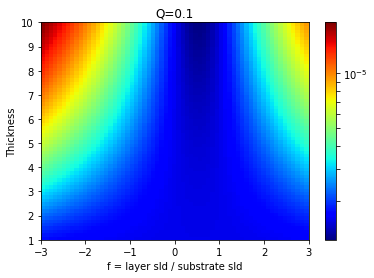

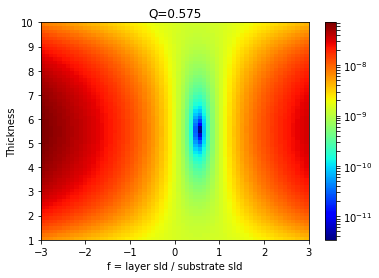

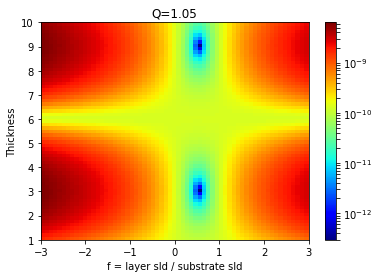

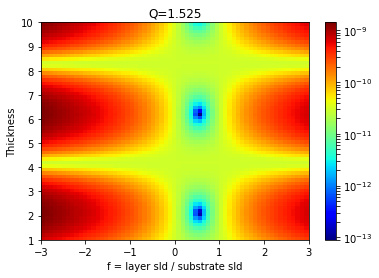

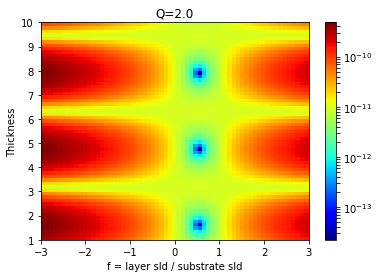

In [51]:
import matplotlib.colors as colors
for i, q in enumerate(np.linspace(0.1,2,5)):
#for i, q in enumerate(np.linspace(0.1,2,100)):
    plt.figure()
    substrate_sld = 1.0
    factors = np.linspace(-3,3,64)
    thicknesses = np.linspace(1.0,10.0,64)
    roughnesses = np.zeros_like(slds)
    qvals = np.array([q])
    refs = np.array([[run_layer_over_substrate(f*substrate_sld,substrate_sld,t,qvals) for f in factors] for t in thicknesses])
    
    xx, yy = np.meshgrid(factors, thicknesses)
    refs = refs.reshape(xx.shape)
    
    
    # Make the plot
    plt.pcolormesh(xx, yy, refs, norm=colors.LogNorm(vmin=refs.min(), vmax=refs.max()), cmap='jet')
    plt.colorbar()
    #for s in thicknesses:
    #    plt.scatter(fingerprints[s],s*np.ones(len(fingerprints[s])),c='k',marker='.', alpha=0.3) 
    plt.xlabel("f = layer sld / substrate sld")
    plt.ylabel("Thickness")
    plt.title("Q="+str(q))
    #plt.savefig("sld_factor_{:02}.png".format(i))
    plt.show()
 #   plt.close(fig='all')

# Other approach:

In [53]:
NUM_SLD_LAYERS = 101
SERIES_NAMES = []
SAVE_TO_PATH = "/media/juan/LinuxWindowsShared/ReflectometryTrainData/"

number_of_layers = NUM_SLD_LAYERS
thicknesses = np.ones(number_of_layers) / number_of_layers
depth = thicknesses.cumsum() 

In [54]:
def fourier(x,y):
    ### Fourier:   
    r = np.nan_to_num(y)
    stepsize= x[1]-x[0]
    fourier = (fft(r).real)
    freq = (fftfreq(q.size, d=stepsize))
    return fftshift(freq), fftshift(fourier**2/fourier[0]**2)

def stack_plot(depth, slds, q, R):
    fig, axs = plt.subplots(3, figsize=(6,6))
    fig.suptitle('SLD profile, $RQ^4$ signal and Fourier Transform')
    
    axs[0].plot(q/np.pi, R, label = "R")
    axs[1].plot(depth, slds, label = "slds")
    axs[2].plot(fourier(q,R)[0]*2*np.pi, fourier(q,R)[1], '-')
    axs[2].grid()
    axs[2].axvline(0, c='k')
    axs[2].axhline(0, c='k')
    axs[2].set_xlim(-0.05,2.05)

    axs[1].axhline(1, c='k', ls='--', alpha = 0.5)
    axs[1].set_ylim(0,max(slds)+2)
    axs[1].legend()
    axs[1].grid()
    plt.show()

def f(i, series_name):
    depth, sld = np.loadtxt(SAVE_TO_PATH+series_name+f"_sld_{i:03}.txt")
    q, r = np.loadtxt(SAVE_TO_PATH+series_name+f"_ref_{i:03}.txt")
    stack_plot(depth, sld, q, r)

In [62]:
#step up profile:
series_name = "step_up"

def step_up(xarr, x0, y0 = 0, y1 = 1):
    y = np.asarray([y0 if x < x0 else y1 for x in xarr])
    return y

if False: #set to True to generate and save data
    count = 0
    for x0 in np.linspace(0,1,number_of_layers):
        slds = step_up(depth, x0, y0=0, y1=10)
        q, r = compute_q_vs_rq4(slds, thicknesses,qrange=[0,16*np.pi])
        np.savetxt(SAVE_TO_PATH+series_name+f"_sld_{count:03}.txt",np.vstack((depth, slds)))
        np.savetxt(SAVE_TO_PATH+series_name+f"_ref_{count:03}.txt",np.vstack((q, r)))
        count += 1

interactive_plot = interactive(f, i=(0,number_of_layers-1), series_name=series_name)
output = interactive_plot.children[-1]
output.layout.height = '400px'
interactive_plot

interactive(children=(IntSlider(value=50, description='i'), Text(value='step_up', description='series_name'), …

In [56]:
#step down profile:
series_name = "step_down"

def step_down(xarr, x0, y0 = 0, y1 = 1):
    y = np.asarray([y1 if x <= x0 else y0 for x in xarr])
    return y


if False: #set to True to generate and save data
    count = 0
    for x0 in np.linspace(0,1,number_of_layers):
        slds = step_down(depth, x0, y0=1, y1=10)
        q, r = compute_q_vs_rq4(slds, thicknesses,qrange=[0,16*np.pi])
        np.savetxt(SAVE_TO_PATH+series_name+f"_sld_{count:03}.txt",np.vstack((depth, slds)))
        np.savetxt(SAVE_TO_PATH+series_name+f"_ref_{count:03}.txt",np.vstack((q, r)))
        count += 1
    
interactive_plot = interactive(f, i=(0,number_of_layers-1), series_name=series_name)
output = interactive_plot.children[-1]
output.layout.height = '400px'
interactive_plot

interactive(children=(IntSlider(value=50, description='i'), Text(value='step_down', description='series_name')…

In [57]:
#box profile:
series_name = "box"

def box(xarr, x0, x1, height = 1):
    y = np.asarray([height if x >= x0 and x < x1 else 0 for x in xarr])
    return y
 
if False: #set to True to generate and save data
    slds = {}
    refsignal = {}
    width = 0.1
    count = 0
    for position in np.linspace(width,1-width,100):
        x0 = position - 0.5*width
        x1 = position + 0.5*width
        slds = box(depth, x0, x1, 10) + box(depth,x1,2.0,1.0)
        q, r = compute_q_vs_rq4(slds, thicknesses,qrange=[0,16*np.pi])
        np.savetxt(SAVE_TO_PATH+series_name+f"_sld_{count:03}.txt",np.vstack((depth, slds)))
        np.savetxt(SAVE_TO_PATH+series_name+f"_ref_{count:03}.txt",np.vstack((q, r)))
        count += 1
    
    position = 0.5
    for width in np.linspace(0.1,0.9,100):
        x0 = position - 0.5*width
        x1 = position + 0.5*width
        slds = box(depth, x0, x1, 10) + box(depth,x1,2.0,1.0)
        q, r = compute_q_vs_rq4(slds, thicknesses,qrange=[0,16*np.pi])
        np.savetxt(SAVE_TO_PATH+series_name+f"_sld_{count:03}.txt",np.vstack((depth, slds)))
        np.savetxt(SAVE_TO_PATH+series_name+f"_ref_{count:03}.txt",np.vstack((q, r)))
        count += 1
    
interactive_plot = interactive(f, i=(0,2*number_of_layers-1), series_name=series_name)
output = interactive_plot.children[-1]
output.layout.height = '400px'
interactive_plot

interactive(children=(IntSlider(value=100, description='i', max=201), Text(value='box', description='series_na…

In [63]:
#double up
series_name = "double_up"

if False: #set to True to generate and save data
    count = 0
    for i in range(len(depth)):
        if i%10 > 0:
            continue
        for j in range(i,len(depth)):
            #if j%10 > 0:
            #    continue
            x0 = depth[i]
            x1 = depth[j]
        
            slds = step_up(depth, x0, y0 = 0, y1 = 5) + \
                   step_up(depth, x1, y0 = 0, y1 = 5)
            
            q, r = compute_q_vs_rq4(slds, thicknesses,qrange=[0,16*np.pi])
            np.savetxt(SAVE_TO_PATH+series_name+f"_sld_{count:03}.txt",np.vstack((depth, slds)))
            np.savetxt(SAVE_TO_PATH+series_name+f"_ref_{count:03}.txt",np.vstack((q, r)))
            count += 1

interactive_plot = interactive(f, i=(0,count), series_name=series_name)
output = interactive_plot.children[-1]
output.layout.height = '400px'
interactive_plot

interactive(children=(IntSlider(value=280, description='i', max=561), Text(value='double_up', description='ser…

In [65]:
#double down
series_name = "double_down"

if False: #set to True to generate and save data
    count = 0
    for i in range(len(depth)):
        if i%10 > 0:
            continue
        for j in range(i,len(depth)):
            #if j%10 > 0:
            #    continue
            x0 = depth[i]
            x1 = depth[j]
        
            slds = step_down(depth, x0, y0 = 0, y1 = 5) + \
                            step_down(depth, x1, y0 = 1, y1 = 5)
            
            q, r = compute_q_vs_rq4(slds, thicknesses,qrange=[0,16*np.pi])
            np.savetxt(SAVE_TO_PATH+series_name+f"_sld_{count:03}.txt",np.vstack((depth, slds)))
            np.savetxt(SAVE_TO_PATH+series_name+f"_ref_{count:03}.txt",np.vstack((q, r)))
            count += 1
        
interactive_plot = interactive(f, i=(0,count), series_name=series_name)
output = interactive_plot.children[-1]
output.layout.height = '400px'
interactive_plot

interactive(children=(IntSlider(value=280, description='i', max=561), Text(value='double_down', description='s…

In [66]:
#double box
series_name = "double_box"

if False: #set to True to generate and save data
    count = 0
    for width_a in np.linspace(0.2,1.0,5):
        for width_b in np.linspace(0.2,1.0,5):
            for position_a in np.linspace(width_a/2.,0.5,5):
                for position_b in np.linspace(0.5,1.0-width_b/2.0,5):
                    x0a = position_a - 0.5*width_a
                    x1a = position_a + 0.5*width_a
        
                    x0b = position_b - 0.5*width_b
                    x1b = position_b + 0.5*width_b
                    slds = box(depth, x0a, x1a, 5.0) + box(depth, x0b, x1b, 5.0)
                    q, r = compute_q_vs_rq4(slds, thicknesses,qrange=[0,16*np.pi])
                    np.savetxt(SAVE_TO_PATH+series_name+f"_sld_{count:03}.txt",np.vstack((depth, slds)))
                    np.savetxt(SAVE_TO_PATH+series_name+f"_ref_{count:03}.txt",np.vstack((q, r)))
                    count += 1
                
interactive_plot = interactive(f, i=(0,count), series_name=series_name)
output = interactive_plot.children[-1]
output.layout.height = '400px'
interactive_plot

interactive(children=(IntSlider(value=280, description='i', max=561), Text(value='double_box', description='se…

In [67]:
#double box (above constant 1 --count starts where we left in the last cell)
series_name = "double_box_up"

if False: #set to True to generate and save data
    count = 0
    for width_a in np.linspace(0.2,1.0,5):
        for width_b in np.linspace(0.2,1.0,5):
            for position_a in np.linspace(width_a/2.,0.5,5):
                for position_b in np.linspace(0.5,1.0-width_b/2.0,5):
                    x0a = position_a - 0.5*width_a
                    x1a = position_a + 0.5*width_a
        
                    x0b = position_b - 0.5*width_b
                    x1b = position_b + 0.5*width_b
                    slds = 1 + box(depth, x0a, x1a, 5.0) + box(depth, x0b, x1b, 5.0)
                    q, r = compute_q_vs_rq4(slds, thicknesses,qrange=[0,16*np.pi])
                    np.savetxt(SAVE_TO_PATH+series_name+f"_sld_{count:03}.txt",np.vstack((depth, slds)))
                    np.savetxt(SAVE_TO_PATH+series_name+f"_ref_{count:03}.txt",np.vstack((q, r)))
                    count += 1
                
interactive_plot = interactive(f, i=(0,count), series_name=series_name)
output = interactive_plot.children[-1]
output.layout.height = '400px'
interactive_plot

interactive(children=(IntSlider(value=280, description='i', max=561), Text(value='double_box_up', description=…

In [68]:
#random boxex
series_name = "random_boxes"

np.random.seed(0)
NumberOfSamples = int(1e6)

if False: #set to True to generate and save data
    count = 0
    for x in tqdm(range(NumberOfSamples)):
        nboxes = 1 + np.random.randint(10)
        a = np.random.random(nboxes)
        b = np.random.random(nboxes)
        x0_ = np.vectorize(min)(a,b)
        x1_ = np.vectorize(max)(a,b)
        h_ = 10*np.random.random(nboxes)
        slds = np.sum(np.asarray([box(depth, x0, x1, h) for x0, x1, h in zip(x0_, x1_, h_)]), axis=0)
        
        q, r = compute_q_vs_rq4(slds, thicknesses,qrange=[0,16*np.pi])
        np.savetxt(SAVE_TO_PATH+series_name+f"_sld_{count:06}.txt",np.vstack((depth, slds)))
        np.savetxt(SAVE_TO_PATH+series_name+f"_ref_{count:06}.txt",np.vstack((q, r)))
        
        count += 1
    print("Saved to: "+SAVE_TO_PATH+"RandomBoxes/"+series_name+f"_ref_{count:03}.txt")

In [73]:
prediction = {}
label = {}
count = 0
while count < 10000:
    try:
        prediction[count], label[count] = np.loadtxt("/media/juan/LinuxWindowsShared/Predictions/random_boxes_{:05}.txt".format(count))
        count += 1
    except:
        break

print("Count:", count)

Count: 10000


In [74]:
number_of_layers = 201
thicknesses = np.ones(number_of_layers) / number_of_layers
depth = thicknesses.cumsum() 

def true_vs_pred_plot(true, pred):
    q, r_true = compute_q_vs_rq4(true, thicknesses)
    q, r_pred = compute_q_vs_rq4(pred, thicknesses)
    
    
    
    fig, axs = plt.subplots(2, figsize=(6,6))
    fig.suptitle('SLD profile, $RQ^4$ signal and Fourier Transform')
    
    axs[0].plot(true, label = "sld_true")
    axs[0].plot(pred, label = "sld_pred")

    axs[1].plot(q, r_true, label = "r_true")
    axs[1].plot(q, r_pred, label = "r_pred")

    #axs[1].axhline(1, c='k', ls='--', alpha = 0.5)
    #axs[1].set_ylim(0,max(slds)+2)
    axs[1].legend()
    axs[1].grid()
    plt.show()
    
def true_vs_pred_interactive_plot(i):
    true_vs_pred_plot(label[i], prediction[i])
        
interactive_plot = interactive(true_vs_pred_interactive_plot, i=(0,count))
output = interactive_plot.children[-1]
output.layout.height = '600px'
interactive_plot

interactive(children=(IntSlider(value=5000, description='i', max=10000), Output(layout=Layout(height='600px'))…

---
# $$ {\rm Summary} $$
***

Due to the non-linearity of the transformation $\rho(z) \, \rightarrow \, R(q)$, i.e. 

$$R\left(\rho_a + \rho_b\right) \, \neq \, R(\rho_a) + R(\rho_b),$$ 

it is not straightforward at all to guess the shape of $\rho(z)$ from the shape of $R(q)$.
However, in this notebook I have tried to build some general ground by which to guess some properties of the sld profile, $\rho(z)$, given a reflectometry curve, $R(q)$.


# Lessons learned:


## For a single layer over a substrate:

The substrate has an SLD $\rho_s$ and the layer over it has an SLD $\rho_l = f \, \rho_s$.
 - Vary sld factor $f$ --> Varies the "amplitude" of the kiessing finges; the "frequency" stays the same.
  - $f$ between 0 and 1 invert the position of the peaks/crests; the effect being strongest for $f = 0.5$
  - For $f = 0$ and $f = 1$, the signal has no bumps
  - The signal has two envelope curves of a functional form $ ~ Q^{-4} \, g(f)\, e^{-1.5 \, h(f)}$
 - Vary thickness --> Varies the "frequency" of kiessing fringes, while the "amplitude" stays the same.
 
## Problem scaling -- Self-similarity (applies for any number of layers):

Letting the "natural" unit of the problem to be the $Q$ range, and rescaling it by a factor $\alpha$:

 - $Q_\alpha = \alpha\, Q$,

the same reflectometry signal is obtained if, at the same time, the following scalings are performed:

 - $\{\rho_i\}_\alpha = \{\alpha^2 \, \rho_i\}$
 - $\{d_i\}_\alpha = \{ \alpha^{-1} \, d_i \}$

where $\rho_i$ and $d_i$ are the SLD and the thickness of the set of layers, including the substrate.

Conversely, the natural unit of the problem can be taken as $\rho_s$ --the substrate SLD. In this case, rescaling $\rho_s$ by a factor $\alpha$,

$\rho_{s,\alpha} = \alpha \, \rho_s$,

the same reflectometry signal is obtained by the following rescalings:

 - $Q_\alpha = \sqrt{\alpha}\, Q$,
 - $\{\rho_i\}_\alpha = \{\alpha \, \rho_i\}$
 - $\{d_i\}_\alpha = \{ \alpha^{-1/2} \, d_i \}$.
 
 
## The period depends on the thickness and the amplitude on the SLD:

 - In the natural units defined by the sld of the substrate, the kiessing finges appear with a period $\Delta Q = 2\pi / d$, where $d$ is the thickness of the layer; i.e. thicker layers produce more fringes for the same $Q$ range.
 - The amplitude of the $RQ^4$ signal evidently has a dependence on the sld of the layer on top of the substrate. In this simple example, we use two envelope functions for modelling the top and the bottom of the signal: a constant $1.5 \times 10^{-10}$ for the lower envelope and a function $ \sim \rho_{\rm layer}^2$ for the upper layer.
 
## The envelopes of the signal:

The top and the bottom envelopes of the $RQ^4$ signal vary as function of the layer SLD.

 - top envelope = $\max(f,g)$,
 - bottom envelope = $\min(f,g)$,

where $f$ and $g$ are defined as follows:

$$f = 2\pi\,(\rho-1/2)^{2} \times 10^{-10}$$,
$$g = {\rm const} = 2\pi\,(1/2)^{2} \times 10^{-10}$$


##  A single step in the sld profile $\rho(z)$ produces a $\sin^2(q)$ shaped reflectometry curve

A $\rho(z)$ *step-up* and *step-down* functions produce, respectively, signals in the $RQ^4$ space with the following forms:


$$RQ^4(q) = R_0 \, \sin^2\left(\frac{(1 - z_0)}{2}\,q\right),$$

$$RQ^4(q) = R_0 \, \sin^2\left(\frac{(z_0)}{2}\,q\right),$$

where the amplitude, $R_0$ is given by:

$$R_0 = 2\pi \, (\rho_0- 1/2)^2 \, \times \,10^{-10}.$$

Using the identity $\sin^2(2\theta) = \frac{1 - \cos(\theta)}{2}$, we can model more complicated wave-forms as a linear combination of cosines.

## A $\rho(z)$ box function is equivalent to a step-up function:

 - The position of the "box" does not change the $RQ^4$ profile.
 - Changing the width of the box is equivalent to changing the leftmost edge of a step-up function.


$$RQ^4(q) = R_0 \, \sin^2\left(\frac{(z1 - z_0)}{2}\,q\right),$$

where the amplitude, $R_0$ is given by (see some cells above in this notebook):

$$R_0 = 2\pi \, (\rho_0- 1/2)^2 \, \times \,10^{-10}$$

Te frequency is related to the position of the step and the amplitude to its height.


## Two $\rho(z)$ steps translate into three cosine waves in the $RQ^4(q)$ space

Two $\rho(z)$ *steps up* and two *steps down* functions produce, respectively, signals in the $RQ^4$ space with the following forms:

$$RQ^4(q) = a_0 + \sum_{1}^{3} a_{i} \cos( \, \omega_i \, q  ),$$

where the coefficients $\{a_i\}$ *seem* to be related to the height of the steps, $\rho_i$, while the frequencies $\omega_i$ *seem* to be related to the thicknesses of the steps, $d_{ij} = z_i-z_j$.